In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,Cropping2D
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py

from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import smooth_tiled_predictions


/home/yokoyang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_mask(image_id):
    filename = os.path.join(
        Dir, 'land', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk_img = np.zeros([size, size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img


def get_image(image_id):
    filename = os.path.join(
        Dir, 'satellite', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))

    return img_RGB


def reflect_img(img):
    reflect = cv2.copyMakeBorder(img, int(edge_size), int(edge_size), int(edge_size), int(edge_size),
                                 cv2.BORDER_REFLECT)
    return reflect


def get_patch(img_id, pos=1):
    img_ = []
    msk_ = []
    img = get_image(img_id)
    img = reflect_img(img)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x_start = int(Patch_size * i)
                x_end = int(Patch_size * (i + 1) + edge_size * 2)

                y_start = int(Patch_size * j)
                y_end = int(Patch_size * (j + 1) + edge_size * 2)
                x = img[x_start:x_end, y_start:y_end, :]
                img_.append(x)

    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                msk_.append(y[:, :, None])

    return img_, msk_


def get_all_patches(pos=1):
    img_all = []
    msk_all = []
    count = 0
    for img_id in Image_ID:
        img_, msk_ = get_patch(img_id, pos=pos)
        if len(msk_) > 0:
            count = count + 1
            if count == 1:
                img_all = img_
                msk_all = msk_
            else:
                img_all = np.concatenate((img_all, img_), axis=0)
                msk_all = np.concatenate((msk_all, msk_), axis=0)

    # if pos == 1:
    #     np.save(Dir + '/output/data_pos_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)
    #
    # else:
    #     np.save(Dir + '/output/data_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)

    return img_all, msk_all[:, :, :, 0]


def get_normalized_patches():
    img_all, msk_all = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = img_all
    msk = msk_all
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk


In [3]:
def get_unet_5():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)

    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv10)

    model = Model(inputs=inputs, outputs=cropping_2d)

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model





In [5]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)

N_split = 4

Patch_size = 256
crop_size = 288
edge_size = int((crop_size - Patch_size) / 2)
Class_Type = 1
# 1200 = 300 * 4
size = 1024
Scale_Size = Patch_size * N_split
get_size = 100


['Amsterdam_0_0', 'Amsterdam_0_1', 'Amsterdam_0_2', 'Amsterdam_0_3', 'Amsterdam_0_4', 'Amsterdam_0_5', 'Amsterdam_0_6', 'Amsterdam_1_0', 'Amsterdam_1_1', 'Amsterdam_1_2', 'Amsterdam_1_3', 'Amsterdam_1_4', 'Amsterdam_1_5', 'Amsterdam_1_6', 'Amsterdam_2_0', 'Amsterdam_2_1', 'Amsterdam_2_2', 'Amsterdam_2_3', 'Amsterdam_2_4', 'Amsterdam_2_5', 'Amsterdam_2_6', 'Amsterdam_3_0', 'Amsterdam_3_1', 'Amsterdam_3_2', 'Amsterdam_3_3', 'Amsterdam_3_4', 'Amsterdam_3_5', 'Amsterdam_3_6', 'Amsterdam_4_0', 'Amsterdam_4_1', 'Amsterdam_4_2', 'Amsterdam_4_3', 'Amsterdam_4_4', 'Amsterdam_4_5', 'Amsterdam_4_6', 'Amsterdam_5_0', 'Amsterdam_5_1', 'Amsterdam_5_2', 'Amsterdam_5_3', 'Amsterdam_5_4', 'Amsterdam_5_5', 'Amsterdam_5_6', 'Berlin_0_0', 'Berlin_0_1', 'Berlin_0_2', 'Berlin_0_3', 'Berlin_0_4', 'Berlin_0_5', 'Berlin_0_6', 'Berlin_1_0', 'Berlin_1_1', 'Berlin_1_2', 'Berlin_1_3', 'Berlin_1_4', 'Berlin_1_5', 'Berlin_1_6', 'Berlin_2_0', 'Berlin_2_1', 'Berlin_2_2', 'Berlin_2_3', 'Berlin_2_4', 'Berlin_2_5', 'Berl

In [6]:
# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.48894683, std=0.2100344):
    img = (img - mean) / std
    return img


In [7]:
all_Image_ID = sorted(train_img.ImageId.unique())
all_len = len(all_Image_ID)
loop_time = all_len // get_size
last_weight = ''
loop_i = 0
for i in range(loop_time):
    Image_ID = random.sample(all_Image_ID, get_size)
    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]
    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_5()
    if i != 0:
        print("loaded")
        model.load_weights(last_weight)

    check_point_file_name = str(loop_i) + '_unet5_c1.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name
    loop_i += 1
    del x_trn, x_val, y_trn, y_val, model

img_last = all_len - loop_time * get_size
if img_last > 0:
    Image_ID = random.sample(all_Image_ID, img_last)
    print(len(Image_ID))

    all_Image_ID = [Image_ID2 for Image_ID2 in all_Image_ID if Image_ID2 not in Image_ID]

    img, msk = get_normalized_patches()
    x_trn, x_val, y_trn, y_val = train_test_split(img, msk, test_size=0.2, random_state=42)
    y_trn = y_trn[:, :, :, None]
    y_val = y_val[:, :, :, None]

    model = get_unet_5()
    if loop_i != 0:
        print("loaded")
        model.load_weights(last_weight)
    # model.load_weights("1unet5_c1.hdf5")
    check_point_file_name = str(loop_i) + '_unet5_c1.hdf5'
    model_checkpoint = ModelCheckpoint(check_point_file_name, save_best_only=True)
    model.fit(x_trn, y_trn, batch_size=16, epochs=20, verbose=1, shuffle=True, callbacks=[model_checkpoint],
              validation_data=(x_val, y_val))
    last_weight = check_point_file_name


0.48938304 0.21025844


3.7375344e-06 1.000001


Train on 994 samples, validate on 249 samples
Epoch 1/20


 16/994 [..............................] - ETA: 5:42 - loss: 0.7720 - acc: 0.3651

 32/994 [..............................] - ETA: 3:14 - loss: 1.5731 - acc: 0.5999

 48/994 [>.............................] - ETA: 2:25 - loss: 1.2275 - acc: 0.6703

 64/994 [>.............................] - ETA: 2:00 - loss: 1.0534 - acc: 0.7024

 80/994 [=>............................] - ETA: 1:44 - loss: 0.9515 - acc: 0.7166

 96/994 [=>............................] - ETA: 1:34 - loss: 0.8640 - acc: 0.7380

112/994 [==>...........................] - ETA: 1:26 - loss: 0.7988 - acc: 0.7529

128/994 [==>...........................] - ETA: 1:20 - loss: 0.7680 - acc: 0.7576

144/994 [===>..........................] - ETA: 1:15 - loss: 0.7402 - acc: 0.7645

160/994 [===>..........................] - ETA: 1:11 - loss: 0.7147 - acc: 0.7689

176/994 [====>.........................] - ETA: 1:07 - loss: 0.6957 - acc: 0.7680

192/994 [====>.........................] - ETA: 1:04 - loss: 0.6720 - acc: 0.7744

208/994 [=====>........................] - ETA: 1:01 - loss: 0.6550 - acc: 0.7759

224/994 [=====>........................] - ETA: 59s - loss: 0.6411 - acc: 0.7784 

240/994 [======>.......................] - ETA: 57s - loss: 0.6316 - acc: 0.7787

256/994 [======>.......................] - ETA: 54s - loss: 0.6172 - acc: 0.7833

272/994 [=======>......................] - ETA: 53s - loss: 0.6086 - acc: 0.7836

288/994 [=======>......................] - ETA: 51s - loss: 0.5993 - acc: 0.7855

304/994 [========>.....................] - ETA: 49s - loss: 0.5907 - acc: 0.7874

320/994 [========>.....................] - ETA: 47s - loss: 0.5838 - acc: 0.7893

336/994 [=========>....................] - ETA: 46s - loss: 0.5774 - acc: 0.7898

352/994 [=========>....................] - ETA: 44s - loss: 0.5738 - acc: 0.7884

368/994 [==========>...................] - ETA: 43s - loss: 0.5679 - acc: 0.7912

384/994 [==========>...................] - ETA: 41s - loss: 0.5628 - acc: 0.7928

400/994 [===========>..................] - ETA: 40s - loss: 0.5576 - acc: 0.7943

416/994 [===========>..................] - ETA: 39s - loss: 0.5509 - acc: 0.7959

432/994 [============>.................] - ETA: 37s - loss: 0.5466 - acc: 0.7962

448/994 [============>.................] - ETA: 36s - loss: 0.5427 - acc: 0.7976

464/994 [=============>................] - ETA: 35s - loss: 0.5431 - acc: 0.7961

480/994 [=============>................] - ETA: 33s - loss: 0.5380 - acc: 0.7976

496/994 [=============>................] - ETA: 32s - loss: 0.5358 - acc: 0.7973

512/994 [==============>...............] - ETA: 31s - loss: 0.5321 - acc: 0.7978

528/994 [==============>...............] - ETA: 30s - loss: 0.5280 - acc: 0.7993

544/994 [===============>..............] - ETA: 29s - loss: 0.5249 - acc: 0.8003

560/994 [===============>..............] - ETA: 28s - loss: 0.5224 - acc: 0.8009

576/994 [================>.............] - ETA: 26s - loss: 0.5203 - acc: 0.8012

592/994 [================>.............] - ETA: 25s - loss: 0.5180 - acc: 0.8015

608/994 [=================>............] - ETA: 24s - loss: 0.5163 - acc: 0.8012

624/994 [=================>............] - ETA: 23s - loss: 0.5135 - acc: 0.8020

640/994 [==================>...........] - ETA: 22s - loss: 0.5113 - acc: 0.8025

656/994 [==================>...........] - ETA: 21s - loss: 0.5112 - acc: 0.8020

672/994 [===================>..........] - ETA: 20s - loss: 0.5080 - acc: 0.8030

688/994 [===================>..........] - ETA: 19s - loss: 0.5063 - acc: 0.8029

704/994 [====================>.........] - ETA: 18s - loss: 0.5058 - acc: 0.8025

720/994 [====================>.........] - ETA: 17s - loss: 0.5034 - acc: 0.8038

736/994 [=====================>........] - ETA: 16s - loss: 0.5021 - acc: 0.8036

752/994 [=====================>........] - ETA: 15s - loss: 0.4999 - acc: 0.8043

768/994 [======================>.......] - ETA: 14s - loss: 0.4976 - acc: 0.8048

784/994 [======================>.......] - ETA: 13s - loss: 0.4948 - acc: 0.8055

800/994 [=======================>......] - ETA: 12s - loss: 0.4906 - acc: 0.8073

816/994 [=======================>......] - ETA: 11s - loss: 0.4884 - acc: 0.8080

832/994 [========================>.....] - ETA: 10s - loss: 0.4874 - acc: 0.8082

848/994 [========================>.....] - ETA: 9s - loss: 0.4865 - acc: 0.8083 

864/994 [=========================>....] - ETA: 8s - loss: 0.4844 - acc: 0.8086

880/994 [=========================>....] - ETA: 7s - loss: 0.4822 - acc: 0.8093

896/994 [==========================>...] - ETA: 6s - loss: 0.4817 - acc: 0.8092

912/994 [==========================>...] - ETA: 5s - loss: 0.4801 - acc: 0.8094

928/994 [===========================>..] - ETA: 4s - loss: 0.4798 - acc: 0.8088

944/994 [===========================>..] - ETA: 3s - loss: 0.4780 - acc: 0.8093

960/994 [===========================>..] - ETA: 2s - loss: 0.4757 - acc: 0.8103

976/994 [============================>.] - ETA: 1s - loss: 0.4751 - acc: 0.8103

992/994 [============================>.] - ETA: 0s - loss: 0.4745 - acc: 0.8100

994/994 [==============================] - 67s 68ms/step - loss: 0.4741 - acc: 0.8102 - val_loss: 0.4036 - val_acc: 0.8263


Epoch 2/20


 16/994 [..............................] - ETA: 55s - loss: 0.4525 - acc: 0.7873

 32/994 [..............................] - ETA: 54s - loss: 0.4431 - acc: 0.7972

 48/994 [>.............................] - ETA: 53s - loss: 0.4418 - acc: 0.8024

 64/994 [>.............................] - ETA: 52s - loss: 0.4298 - acc: 0.8107

 80/994 [=>............................] - ETA: 51s - loss: 0.4436 - acc: 0.8080

 96/994 [=>............................] - ETA: 50s - loss: 0.4338 - acc: 0.8142

112/994 [==>...........................] - ETA: 49s - loss: 0.4329 - acc: 0.8181

128/994 [==>...........................] - ETA: 48s - loss: 0.4292 - acc: 0.8193

144/994 [===>..........................] - ETA: 48s - loss: 0.4281 - acc: 0.8211

160/994 [===>..........................] - ETA: 47s - loss: 0.4207 - acc: 0.8268

176/994 [====>.........................] - ETA: 46s - loss: 0.4224 - acc: 0.8251

192/994 [====>.........................] - ETA: 45s - loss: 0.4242 - acc: 0.8235

208/994 [=====>........................] - ETA: 44s - loss: 0.4262 - acc: 0.8217

224/994 [=====>........................] - ETA: 43s - loss: 0.4285 - acc: 0.8194

240/994 [======>.......................] - ETA: 42s - loss: 0.4297 - acc: 0.8187

256/994 [======>.......................] - ETA: 41s - loss: 0.4256 - acc: 0.8202

272/994 [=======>......................] - ETA: 40s - loss: 0.4248 - acc: 0.8207

288/994 [=======>......................] - ETA: 39s - loss: 0.4218 - acc: 0.8221

304/994 [========>.....................] - ETA: 38s - loss: 0.4215 - acc: 0.8229

320/994 [========>.....................] - ETA: 38s - loss: 0.4189 - acc: 0.8237

336/994 [=========>....................] - ETA: 37s - loss: 0.4177 - acc: 0.8246

352/994 [=========>....................] - ETA: 36s - loss: 0.4189 - acc: 0.8234

368/994 [==========>...................] - ETA: 35s - loss: 0.4179 - acc: 0.8231

384/994 [==========>...................] - ETA: 34s - loss: 0.4170 - acc: 0.8233

400/994 [===========>..................] - ETA: 33s - loss: 0.4164 - acc: 0.8232

416/994 [===========>..................] - ETA: 32s - loss: 0.4161 - acc: 0.8238

432/994 [============>.................] - ETA: 31s - loss: 0.4184 - acc: 0.8223

448/994 [============>.................] - ETA: 30s - loss: 0.4167 - acc: 0.8231

464/994 [=============>................] - ETA: 29s - loss: 0.4154 - acc: 0.8237

480/994 [=============>................] - ETA: 29s - loss: 0.4146 - acc: 0.8237

496/994 [=============>................] - ETA: 28s - loss: 0.4120 - acc: 0.8249

512/994 [==============>...............] - ETA: 27s - loss: 0.4115 - acc: 0.8253

528/994 [==============>...............] - ETA: 26s - loss: 0.4095 - acc: 0.8259

544/994 [===============>..............] - ETA: 25s - loss: 0.4096 - acc: 0.8260

560/994 [===============>..............] - ETA: 24s - loss: 0.4083 - acc: 0.8267

576/994 [================>.............] - ETA: 23s - loss: 0.4062 - acc: 0.8277

592/994 [================>.............] - ETA: 22s - loss: 0.4050 - acc: 0.8283

608/994 [=================>............] - ETA: 21s - loss: 0.4050 - acc: 0.8284

624/994 [=================>............] - ETA: 20s - loss: 0.4030 - acc: 0.8292

640/994 [==================>...........] - ETA: 19s - loss: 0.4036 - acc: 0.8289

656/994 [==================>...........] - ETA: 19s - loss: 0.4044 - acc: 0.8288

672/994 [===================>..........] - ETA: 18s - loss: 0.4038 - acc: 0.8294

688/994 [===================>..........] - ETA: 17s - loss: 0.4027 - acc: 0.8299

704/994 [====================>.........] - ETA: 16s - loss: 0.4025 - acc: 0.8302

720/994 [====================>.........] - ETA: 15s - loss: 0.4010 - acc: 0.8310

736/994 [=====================>........] - ETA: 14s - loss: 0.4006 - acc: 0.8310

752/994 [=====================>........] - ETA: 13s - loss: 0.4011 - acc: 0.8306

768/994 [======================>.......] - ETA: 12s - loss: 0.4004 - acc: 0.8308

784/994 [======================>.......] - ETA: 11s - loss: 0.3999 - acc: 0.8309

800/994 [=======================>......] - ETA: 10s - loss: 0.3990 - acc: 0.8312

816/994 [=======================>......] - ETA: 10s - loss: 0.3980 - acc: 0.8317

832/994 [========================>.....] - ETA: 9s - loss: 0.3965 - acc: 0.8324 

848/994 [========================>.....] - ETA: 8s - loss: 0.3938 - acc: 0.8337

864/994 [=========================>....] - ETA: 7s - loss: 0.3925 - acc: 0.8345

880/994 [=========================>....] - ETA: 6s - loss: 0.3913 - acc: 0.8351

896/994 [==========================>...] - ETA: 5s - loss: 0.3895 - acc: 0.8359

912/994 [==========================>...] - ETA: 4s - loss: 0.3880 - acc: 0.8366

928/994 [===========================>..] - ETA: 3s - loss: 0.3871 - acc: 0.8369

944/994 [===========================>..] - ETA: 2s - loss: 0.3864 - acc: 0.8372

960/994 [===========================>..] - ETA: 1s - loss: 0.3856 - acc: 0.8375

976/994 [============================>.] - ETA: 1s - loss: 0.3857 - acc: 0.8372

992/994 [============================>.] - ETA: 0s - loss: 0.3860 - acc: 0.8368

994/994 [==============================] - 61s 61ms/step - loss: 0.3860 - acc: 0.8368 - val_loss: 0.3681 - val_acc: 0.8381


Epoch 3/20


 16/994 [..............................] - ETA: 55s - loss: 0.3620 - acc: 0.8366

 32/994 [..............................] - ETA: 54s - loss: 0.3357 - acc: 0.8514

 48/994 [>.............................] - ETA: 53s - loss: 0.3438 - acc: 0.8523

 64/994 [>.............................] - ETA: 52s - loss: 0.3476 - acc: 0.8517

 80/994 [=>............................] - ETA: 51s - loss: 0.3414 - acc: 0.8573

 96/994 [=>............................] - ETA: 50s - loss: 0.3470 - acc: 0.8519

112/994 [==>...........................] - ETA: 49s - loss: 0.3441 - acc: 0.8536

128/994 [==>...........................] - ETA: 49s - loss: 0.3389 - acc: 0.8578

144/994 [===>..........................] - ETA: 48s - loss: 0.3405 - acc: 0.8592

160/994 [===>..........................] - ETA: 47s - loss: 0.3348 - acc: 0.8618

176/994 [====>.........................] - ETA: 46s - loss: 0.3362 - acc: 0.8614

192/994 [====>.........................] - ETA: 45s - loss: 0.3366 - acc: 0.8606

208/994 [=====>........................] - ETA: 44s - loss: 0.3386 - acc: 0.8593

224/994 [=====>........................] - ETA: 43s - loss: 0.3401 - acc: 0.8584

240/994 [======>.......................] - ETA: 42s - loss: 0.3391 - acc: 0.8585

256/994 [======>.......................] - ETA: 41s - loss: 0.3379 - acc: 0.8594

272/994 [=======>......................] - ETA: 40s - loss: 0.3371 - acc: 0.8599

288/994 [=======>......................] - ETA: 39s - loss: 0.3363 - acc: 0.8604

304/994 [========>.....................] - ETA: 39s - loss: 0.3383 - acc: 0.8597

320/994 [========>.....................] - ETA: 38s - loss: 0.3387 - acc: 0.8597

336/994 [=========>....................] - ETA: 37s - loss: 0.3370 - acc: 0.8607

352/994 [=========>....................] - ETA: 36s - loss: 0.3362 - acc: 0.8607

368/994 [==========>...................] - ETA: 35s - loss: 0.3368 - acc: 0.8604

384/994 [==========>...................] - ETA: 34s - loss: 0.3356 - acc: 0.8609

400/994 [===========>..................] - ETA: 33s - loss: 0.3367 - acc: 0.8605

416/994 [===========>..................] - ETA: 32s - loss: 0.3373 - acc: 0.8600

432/994 [============>.................] - ETA: 31s - loss: 0.3364 - acc: 0.8604

448/994 [============>.................] - ETA: 30s - loss: 0.3380 - acc: 0.8597

464/994 [=============>................] - ETA: 30s - loss: 0.3382 - acc: 0.8595

480/994 [=============>................] - ETA: 29s - loss: 0.3400 - acc: 0.8585

496/994 [=============>................] - ETA: 28s - loss: 0.3399 - acc: 0.8585

512/994 [==============>...............] - ETA: 27s - loss: 0.3366 - acc: 0.8601

528/994 [==============>...............] - ETA: 26s - loss: 0.3356 - acc: 0.8603

544/994 [===============>..............] - ETA: 25s - loss: 0.3350 - acc: 0.8605

560/994 [===============>..............] - ETA: 24s - loss: 0.3347 - acc: 0.8606

576/994 [================>.............] - ETA: 23s - loss: 0.3315 - acc: 0.8621

592/994 [================>.............] - ETA: 22s - loss: 0.3319 - acc: 0.8620

608/994 [=================>............] - ETA: 21s - loss: 0.3288 - acc: 0.8634

624/994 [=================>............] - ETA: 20s - loss: 0.3289 - acc: 0.8633

640/994 [==================>...........] - ETA: 20s - loss: 0.3295 - acc: 0.8627

656/994 [==================>...........] - ETA: 19s - loss: 0.3300 - acc: 0.8627

672/994 [===================>..........] - ETA: 18s - loss: 0.3309 - acc: 0.8623

688/994 [===================>..........] - ETA: 17s - loss: 0.3303 - acc: 0.8626

704/994 [====================>.........] - ETA: 16s - loss: 0.3304 - acc: 0.8626

720/994 [====================>.........] - ETA: 15s - loss: 0.3303 - acc: 0.8626

736/994 [=====================>........] - ETA: 14s - loss: 0.3307 - acc: 0.8626

752/994 [=====================>........] - ETA: 13s - loss: 0.3303 - acc: 0.8627

768/994 [======================>.......] - ETA: 12s - loss: 0.3299 - acc: 0.8628

784/994 [======================>.......] - ETA: 11s - loss: 0.3294 - acc: 0.8630

800/994 [=======================>......] - ETA: 10s - loss: 0.3298 - acc: 0.8626

816/994 [=======================>......] - ETA: 10s - loss: 0.3310 - acc: 0.8628

832/994 [========================>.....] - ETA: 9s - loss: 0.3332 - acc: 0.8620 

848/994 [========================>.....] - ETA: 8s - loss: 0.3342 - acc: 0.8615

864/994 [=========================>....] - ETA: 7s - loss: 0.3346 - acc: 0.8618

880/994 [=========================>....] - ETA: 6s - loss: 0.3355 - acc: 0.8619

896/994 [==========================>...] - ETA: 5s - loss: 0.3364 - acc: 0.8618

912/994 [==========================>...] - ETA: 4s - loss: 0.3360 - acc: 0.8624

928/994 [===========================>..] - ETA: 3s - loss: 0.3356 - acc: 0.8626

944/994 [===========================>..] - ETA: 2s - loss: 0.3332 - acc: 0.8639

960/994 [===========================>..] - ETA: 1s - loss: 0.3329 - acc: 0.8641

976/994 [============================>.] - ETA: 1s - loss: 0.3345 - acc: 0.8638

992/994 [============================>.] - ETA: 0s - loss: 0.3342 - acc: 0.8639

994/994 [==============================] - 61s 61ms/step - loss: 0.3342 - acc: 0.8638 - val_loss: 0.3392 - val_acc: 0.8588


Epoch 4/20


 16/994 [..............................] - ETA: 55s - loss: 0.3326 - acc: 0.8672

 32/994 [..............................] - ETA: 54s - loss: 0.3441 - acc: 0.8566

 48/994 [>.............................] - ETA: 53s - loss: 0.3268 - acc: 0.8662

 64/994 [>.............................] - ETA: 52s - loss: 0.3494 - acc: 0.8563

 80/994 [=>............................] - ETA: 51s - loss: 0.3348 - acc: 0.8641

 96/994 [=>............................] - ETA: 50s - loss: 0.3404 - acc: 0.8647

112/994 [==>...........................] - ETA: 49s - loss: 0.3368 - acc: 0.8663

128/994 [==>...........................] - ETA: 49s - loss: 0.3392 - acc: 0.8663

144/994 [===>..........................] - ETA: 48s - loss: 0.3397 - acc: 0.8657

160/994 [===>..........................] - ETA: 47s - loss: 0.3398 - acc: 0.8653

176/994 [====>.........................] - ETA: 46s - loss: 0.3379 - acc: 0.8648

192/994 [====>.........................] - ETA: 45s - loss: 0.3412 - acc: 0.8626

208/994 [=====>........................] - ETA: 44s - loss: 0.3443 - acc: 0.8611

224/994 [=====>........................] - ETA: 43s - loss: 0.3405 - acc: 0.8628

240/994 [======>.......................] - ETA: 42s - loss: 0.3389 - acc: 0.8635

256/994 [======>.......................] - ETA: 41s - loss: 0.3362 - acc: 0.8643

272/994 [=======>......................] - ETA: 40s - loss: 0.3346 - acc: 0.8652

288/994 [=======>......................] - ETA: 39s - loss: 0.3341 - acc: 0.8661

304/994 [========>.....................] - ETA: 39s - loss: 0.3312 - acc: 0.8675

320/994 [========>.....................] - ETA: 38s - loss: 0.3270 - acc: 0.8695

336/994 [=========>....................] - ETA: 37s - loss: 0.3256 - acc: 0.8699

352/994 [=========>....................] - ETA: 36s - loss: 0.3288 - acc: 0.8684

368/994 [==========>...................] - ETA: 35s - loss: 0.3300 - acc: 0.8674

384/994 [==========>...................] - ETA: 34s - loss: 0.3310 - acc: 0.8672

400/994 [===========>..................] - ETA: 33s - loss: 0.3293 - acc: 0.8677

416/994 [===========>..................] - ETA: 32s - loss: 0.3279 - acc: 0.8684

432/994 [============>.................] - ETA: 31s - loss: 0.3238 - acc: 0.8701

448/994 [============>.................] - ETA: 30s - loss: 0.3223 - acc: 0.8706

464/994 [=============>................] - ETA: 30s - loss: 0.3215 - acc: 0.8706

480/994 [=============>................] - ETA: 29s - loss: 0.3216 - acc: 0.8704

496/994 [=============>................] - ETA: 28s - loss: 0.3216 - acc: 0.8705

512/994 [==============>...............] - ETA: 27s - loss: 0.3215 - acc: 0.8705

528/994 [==============>...............] - ETA: 26s - loss: 0.3182 - acc: 0.8717

544/994 [===============>..............] - ETA: 25s - loss: 0.3180 - acc: 0.8718

560/994 [===============>..............] - ETA: 24s - loss: 0.3172 - acc: 0.8717

576/994 [================>.............] - ETA: 23s - loss: 0.3151 - acc: 0.8726

592/994 [================>.............] - ETA: 22s - loss: 0.3156 - acc: 0.8726

608/994 [=================>............] - ETA: 21s - loss: 0.3157 - acc: 0.8727

624/994 [=================>............] - ETA: 20s - loss: 0.3141 - acc: 0.8735

640/994 [==================>...........] - ETA: 20s - loss: 0.3132 - acc: 0.8739

656/994 [==================>...........] - ETA: 19s - loss: 0.3113 - acc: 0.8747

672/994 [===================>..........] - ETA: 18s - loss: 0.3115 - acc: 0.8745

688/994 [===================>..........] - ETA: 17s - loss: 0.3115 - acc: 0.8745

704/994 [====================>.........] - ETA: 16s - loss: 0.3106 - acc: 0.8747

720/994 [====================>.........] - ETA: 15s - loss: 0.3103 - acc: 0.8747

736/994 [=====================>........] - ETA: 14s - loss: 0.3096 - acc: 0.8750

752/994 [=====================>........] - ETA: 13s - loss: 0.3090 - acc: 0.8752

768/994 [======================>.......] - ETA: 12s - loss: 0.3105 - acc: 0.8745

784/994 [======================>.......] - ETA: 11s - loss: 0.3095 - acc: 0.8751

800/994 [=======================>......] - ETA: 10s - loss: 0.3092 - acc: 0.8753

816/994 [=======================>......] - ETA: 10s - loss: 0.3075 - acc: 0.8760

832/994 [========================>.....] - ETA: 9s - loss: 0.3090 - acc: 0.8754 

848/994 [========================>.....] - ETA: 8s - loss: 0.3088 - acc: 0.8753

864/994 [=========================>....] - ETA: 7s - loss: 0.3080 - acc: 0.8757

880/994 [=========================>....] - ETA: 6s - loss: 0.3081 - acc: 0.8755

896/994 [==========================>...] - ETA: 5s - loss: 0.3085 - acc: 0.8752

912/994 [==========================>...] - ETA: 4s - loss: 0.3082 - acc: 0.8752

928/994 [===========================>..] - ETA: 3s - loss: 0.3075 - acc: 0.8755

944/994 [===========================>..] - ETA: 2s - loss: 0.3070 - acc: 0.8756

960/994 [===========================>..] - ETA: 1s - loss: 0.3062 - acc: 0.8758

976/994 [============================>.] - ETA: 1s - loss: 0.3061 - acc: 0.8759

992/994 [============================>.] - ETA: 0s - loss: 0.3052 - acc: 0.8763

994/994 [==============================] - 61s 61ms/step - loss: 0.3051 - acc: 0.8764 - val_loss: 0.2903 - val_acc: 0.8844


Epoch 5/20


 16/994 [..............................] - ETA: 55s - loss: 0.2506 - acc: 0.8985

 32/994 [..............................] - ETA: 54s - loss: 0.2750 - acc: 0.8853

 48/994 [>.............................] - ETA: 53s - loss: 0.2849 - acc: 0.8814

 64/994 [>.............................] - ETA: 52s - loss: 0.2617 - acc: 0.8922

 80/994 [=>............................] - ETA: 51s - loss: 0.2923 - acc: 0.8802

 96/994 [=>............................] - ETA: 50s - loss: 0.2879 - acc: 0.8833

112/994 [==>...........................] - ETA: 49s - loss: 0.2931 - acc: 0.8815

128/994 [==>...........................] - ETA: 49s - loss: 0.2915 - acc: 0.8825

144/994 [===>..........................] - ETA: 48s - loss: 0.2890 - acc: 0.8841

160/994 [===>..........................] - ETA: 47s - loss: 0.2854 - acc: 0.8858

176/994 [====>.........................] - ETA: 46s - loss: 0.2879 - acc: 0.8836

192/994 [====>.........................] - ETA: 45s - loss: 0.2861 - acc: 0.8852

208/994 [=====>........................] - ETA: 44s - loss: 0.2906 - acc: 0.8831

224/994 [=====>........................] - ETA: 43s - loss: 0.2956 - acc: 0.8810

240/994 [======>.......................] - ETA: 42s - loss: 0.2916 - acc: 0.8831

256/994 [======>.......................] - ETA: 41s - loss: 0.2951 - acc: 0.8811

272/994 [=======>......................] - ETA: 40s - loss: 0.2922 - acc: 0.8824

288/994 [=======>......................] - ETA: 40s - loss: 0.2916 - acc: 0.8826

304/994 [========>.....................] - ETA: 39s - loss: 0.2922 - acc: 0.8827

320/994 [========>.....................] - ETA: 38s - loss: 0.2896 - acc: 0.8836

336/994 [=========>....................] - ETA: 37s - loss: 0.2849 - acc: 0.8854

352/994 [=========>....................] - ETA: 36s - loss: 0.2854 - acc: 0.8852

368/994 [==========>...................] - ETA: 35s - loss: 0.2872 - acc: 0.8844

384/994 [==========>...................] - ETA: 34s - loss: 0.2880 - acc: 0.8843

400/994 [===========>..................] - ETA: 33s - loss: 0.2861 - acc: 0.8850

416/994 [===========>..................] - ETA: 32s - loss: 0.2865 - acc: 0.8844

432/994 [============>.................] - ETA: 31s - loss: 0.2892 - acc: 0.8836

448/994 [============>.................] - ETA: 31s - loss: 0.2894 - acc: 0.8837

464/994 [=============>................] - ETA: 30s - loss: 0.2905 - acc: 0.8829

480/994 [=============>................] - ETA: 29s - loss: 0.2908 - acc: 0.8827

496/994 [=============>................] - ETA: 28s - loss: 0.2903 - acc: 0.8830

512/994 [==============>...............] - ETA: 27s - loss: 0.2915 - acc: 0.8823

528/994 [==============>...............] - ETA: 26s - loss: 0.2910 - acc: 0.8827

544/994 [===============>..............] - ETA: 25s - loss: 0.2897 - acc: 0.8832

560/994 [===============>..............] - ETA: 24s - loss: 0.2901 - acc: 0.8830

576/994 [================>.............] - ETA: 23s - loss: 0.2905 - acc: 0.8827

592/994 [================>.............] - ETA: 22s - loss: 0.2896 - acc: 0.8830

608/994 [=================>............] - ETA: 21s - loss: 0.2901 - acc: 0.8826

624/994 [=================>............] - ETA: 20s - loss: 0.2936 - acc: 0.8810

640/994 [==================>...........] - ETA: 20s - loss: 0.2933 - acc: 0.8812

656/994 [==================>...........] - ETA: 19s - loss: 0.2928 - acc: 0.8814

672/994 [===================>..........] - ETA: 18s - loss: 0.2916 - acc: 0.8820

688/994 [===================>..........] - ETA: 17s - loss: 0.2917 - acc: 0.8819

704/994 [====================>.........] - ETA: 16s - loss: 0.2920 - acc: 0.8815

720/994 [====================>.........] - ETA: 15s - loss: 0.2925 - acc: 0.8812

736/994 [=====================>........] - ETA: 14s - loss: 0.2928 - acc: 0.8811

752/994 [=====================>........] - ETA: 13s - loss: 0.2933 - acc: 0.8808

768/994 [======================>.......] - ETA: 12s - loss: 0.2935 - acc: 0.8807

784/994 [======================>.......] - ETA: 11s - loss: 0.2946 - acc: 0.8802

800/994 [=======================>......] - ETA: 11s - loss: 0.2939 - acc: 0.8806

816/994 [=======================>......] - ETA: 10s - loss: 0.2940 - acc: 0.8806

832/994 [========================>.....] - ETA: 9s - loss: 0.2928 - acc: 0.8811 

848/994 [========================>.....] - ETA: 8s - loss: 0.2926 - acc: 0.8811

864/994 [=========================>....] - ETA: 7s - loss: 0.2927 - acc: 0.8810

880/994 [=========================>....] - ETA: 6s - loss: 0.2928 - acc: 0.8811

896/994 [==========================>...] - ETA: 5s - loss: 0.2927 - acc: 0.8811

912/994 [==========================>...] - ETA: 4s - loss: 0.2916 - acc: 0.8816

928/994 [===========================>..] - ETA: 3s - loss: 0.2916 - acc: 0.8816

944/994 [===========================>..] - ETA: 2s - loss: 0.2914 - acc: 0.8817

960/994 [===========================>..] - ETA: 1s - loss: 0.2902 - acc: 0.8821

976/994 [============================>.] - ETA: 1s - loss: 0.2900 - acc: 0.8825

992/994 [============================>.] - ETA: 0s - loss: 0.2905 - acc: 0.8822

994/994 [==============================] - 61s 61ms/step - loss: 0.2905 - acc: 0.8822 - val_loss: 0.2825 - val_acc: 0.8863


Epoch 6/20


 16/994 [..............................] - ETA: 56s - loss: 0.2409 - acc: 0.9042

 32/994 [..............................] - ETA: 54s - loss: 0.2662 - acc: 0.8905

 48/994 [>.............................] - ETA: 53s - loss: 0.2790 - acc: 0.8817

 64/994 [>.............................] - ETA: 53s - loss: 0.2646 - acc: 0.8890

 80/994 [=>............................] - ETA: 52s - loss: 0.2662 - acc: 0.8893

 96/994 [=>............................] - ETA: 51s - loss: 0.2743 - acc: 0.8864

112/994 [==>...........................] - ETA: 50s - loss: 0.2770 - acc: 0.8858

128/994 [==>...........................] - ETA: 49s - loss: 0.2765 - acc: 0.8864

144/994 [===>..........................] - ETA: 48s - loss: 0.2791 - acc: 0.8847

160/994 [===>..........................] - ETA: 47s - loss: 0.2762 - acc: 0.8862

176/994 [====>.........................] - ETA: 46s - loss: 0.2830 - acc: 0.8840

192/994 [====>.........................] - ETA: 45s - loss: 0.2824 - acc: 0.8837

208/994 [=====>........................] - ETA: 44s - loss: 0.2777 - acc: 0.8860

224/994 [=====>........................] - ETA: 43s - loss: 0.2773 - acc: 0.8864

240/994 [======>.......................] - ETA: 42s - loss: 0.2779 - acc: 0.8859

256/994 [======>.......................] - ETA: 41s - loss: 0.2801 - acc: 0.8853

272/994 [=======>......................] - ETA: 41s - loss: 0.2796 - acc: 0.8856

288/994 [=======>......................] - ETA: 40s - loss: 0.2802 - acc: 0.8857

304/994 [========>.....................] - ETA: 39s - loss: 0.2777 - acc: 0.8870

320/994 [========>.....................] - ETA: 38s - loss: 0.2759 - acc: 0.8877

336/994 [=========>....................] - ETA: 37s - loss: 0.2774 - acc: 0.8870

352/994 [=========>....................] - ETA: 36s - loss: 0.2777 - acc: 0.8870

368/994 [==========>...................] - ETA: 35s - loss: 0.2783 - acc: 0.8864

384/994 [==========>...................] - ETA: 34s - loss: 0.2761 - acc: 0.8874

400/994 [===========>..................] - ETA: 33s - loss: 0.2755 - acc: 0.8877

416/994 [===========>..................] - ETA: 32s - loss: 0.2762 - acc: 0.8875

432/994 [============>.................] - ETA: 31s - loss: 0.2783 - acc: 0.8868

448/994 [============>.................] - ETA: 31s - loss: 0.2787 - acc: 0.8867

464/994 [=============>................] - ETA: 30s - loss: 0.2784 - acc: 0.8870

480/994 [=============>................] - ETA: 29s - loss: 0.2783 - acc: 0.8870

496/994 [=============>................] - ETA: 28s - loss: 0.2769 - acc: 0.8876

512/994 [==============>...............] - ETA: 27s - loss: 0.2760 - acc: 0.8879

528/994 [==============>...............] - ETA: 26s - loss: 0.2760 - acc: 0.8879

544/994 [===============>..............] - ETA: 25s - loss: 0.2761 - acc: 0.8879

560/994 [===============>..............] - ETA: 24s - loss: 0.2757 - acc: 0.8882

576/994 [================>.............] - ETA: 23s - loss: 0.2750 - acc: 0.8882

592/994 [================>.............] - ETA: 22s - loss: 0.2765 - acc: 0.8874

608/994 [=================>............] - ETA: 21s - loss: 0.2787 - acc: 0.8864

624/994 [=================>............] - ETA: 21s - loss: 0.2784 - acc: 0.8867

640/994 [==================>...........] - ETA: 20s - loss: 0.2792 - acc: 0.8862

656/994 [==================>...........] - ETA: 19s - loss: 0.2781 - acc: 0.8867

672/994 [===================>..........] - ETA: 18s - loss: 0.2787 - acc: 0.8865

688/994 [===================>..........] - ETA: 17s - loss: 0.2765 - acc: 0.8875

704/994 [====================>.........] - ETA: 16s - loss: 0.2756 - acc: 0.8879

720/994 [====================>.........] - ETA: 15s - loss: 0.2748 - acc: 0.8882

736/994 [=====================>........] - ETA: 14s - loss: 0.2749 - acc: 0.8882

752/994 [=====================>........] - ETA: 13s - loss: 0.2747 - acc: 0.8883

768/994 [======================>.......] - ETA: 12s - loss: 0.2740 - acc: 0.8887

784/994 [======================>.......] - ETA: 11s - loss: 0.2733 - acc: 0.8891

800/994 [=======================>......] - ETA: 11s - loss: 0.2729 - acc: 0.8894

816/994 [=======================>......] - ETA: 10s - loss: 0.2729 - acc: 0.8895

832/994 [========================>.....] - ETA: 9s - loss: 0.2724 - acc: 0.8897 

848/994 [========================>.....] - ETA: 8s - loss: 0.2728 - acc: 0.8895

864/994 [=========================>....] - ETA: 7s - loss: 0.2740 - acc: 0.8891

880/994 [=========================>....] - ETA: 6s - loss: 0.2736 - acc: 0.8893

896/994 [==========================>...] - ETA: 5s - loss: 0.2762 - acc: 0.8883

912/994 [==========================>...] - ETA: 4s - loss: 0.2771 - acc: 0.8880

928/994 [===========================>..] - ETA: 3s - loss: 0.2774 - acc: 0.8878

944/994 [===========================>..] - ETA: 2s - loss: 0.2779 - acc: 0.8875

960/994 [===========================>..] - ETA: 1s - loss: 0.2786 - acc: 0.8873

976/994 [============================>.] - ETA: 1s - loss: 0.2784 - acc: 0.8875

992/994 [============================>.] - ETA: 0s - loss: 0.2778 - acc: 0.8878

994/994 [==============================] - 61s 61ms/step - loss: 0.2781 - acc: 0.8877 - val_loss: 0.2999 - val_acc: 0.8774


Epoch 7/20


 16/994 [..............................] - ETA: 56s - loss: 0.4089 - acc: 0.8115

 32/994 [..............................] - ETA: 54s - loss: 0.3340 - acc: 0.8554

 48/994 [>.............................] - ETA: 53s - loss: 0.3206 - acc: 0.8638

 64/994 [>.............................] - ETA: 52s - loss: 0.3028 - acc: 0.8730

 80/994 [=>............................] - ETA: 51s - loss: 0.2968 - acc: 0.8764

 96/994 [=>............................] - ETA: 51s - loss: 0.2896 - acc: 0.8808

112/994 [==>...........................] - ETA: 50s - loss: 0.2873 - acc: 0.8810

128/994 [==>...........................] - ETA: 49s - loss: 0.2873 - acc: 0.8806

144/994 [===>..........................] - ETA: 48s - loss: 0.2835 - acc: 0.8836

160/994 [===>..........................] - ETA: 47s - loss: 0.2829 - acc: 0.8850

176/994 [====>.........................] - ETA: 46s - loss: 0.2828 - acc: 0.8844

192/994 [====>.........................] - ETA: 45s - loss: 0.2793 - acc: 0.8861

208/994 [=====>........................] - ETA: 44s - loss: 0.2739 - acc: 0.8884

224/994 [=====>........................] - ETA: 43s - loss: 0.2725 - acc: 0.8893

240/994 [======>.......................] - ETA: 42s - loss: 0.2721 - acc: 0.8899

256/994 [======>.......................] - ETA: 41s - loss: 0.2684 - acc: 0.8918

272/994 [=======>......................] - ETA: 41s - loss: 0.2699 - acc: 0.8912

288/994 [=======>......................] - ETA: 40s - loss: 0.2713 - acc: 0.8909

304/994 [========>.....................] - ETA: 39s - loss: 0.2686 - acc: 0.8920

320/994 [========>.....................] - ETA: 38s - loss: 0.2678 - acc: 0.8926

336/994 [=========>....................] - ETA: 37s - loss: 0.2664 - acc: 0.8931

352/994 [=========>....................] - ETA: 36s - loss: 0.2673 - acc: 0.8927

368/994 [==========>...................] - ETA: 35s - loss: 0.2700 - acc: 0.8916

384/994 [==========>...................] - ETA: 34s - loss: 0.2669 - acc: 0.8931

400/994 [===========>..................] - ETA: 33s - loss: 0.2666 - acc: 0.8930

416/994 [===========>..................] - ETA: 32s - loss: 0.2668 - acc: 0.8929

432/994 [============>.................] - ETA: 31s - loss: 0.2657 - acc: 0.8933

448/994 [============>.................] - ETA: 31s - loss: 0.2672 - acc: 0.8922

464/994 [=============>................] - ETA: 30s - loss: 0.2659 - acc: 0.8927

480/994 [=============>................] - ETA: 29s - loss: 0.2659 - acc: 0.8924

496/994 [=============>................] - ETA: 28s - loss: 0.2659 - acc: 0.8923

512/994 [==============>...............] - ETA: 27s - loss: 0.2647 - acc: 0.8929

528/994 [==============>...............] - ETA: 26s - loss: 0.2623 - acc: 0.8939

544/994 [===============>..............] - ETA: 25s - loss: 0.2632 - acc: 0.8937

560/994 [===============>..............] - ETA: 24s - loss: 0.2648 - acc: 0.8930

576/994 [================>.............] - ETA: 23s - loss: 0.2626 - acc: 0.8941

592/994 [================>.............] - ETA: 22s - loss: 0.2631 - acc: 0.8938

608/994 [=================>............] - ETA: 21s - loss: 0.2624 - acc: 0.8943

624/994 [=================>............] - ETA: 21s - loss: 0.2629 - acc: 0.8940

640/994 [==================>...........] - ETA: 20s - loss: 0.2634 - acc: 0.8939

656/994 [==================>...........] - ETA: 19s - loss: 0.2621 - acc: 0.8945

672/994 [===================>..........] - ETA: 18s - loss: 0.2616 - acc: 0.8947

688/994 [===================>..........] - ETA: 17s - loss: 0.2641 - acc: 0.8940

704/994 [====================>.........] - ETA: 16s - loss: 0.2641 - acc: 0.8940

720/994 [====================>.........] - ETA: 15s - loss: 0.2629 - acc: 0.8946

736/994 [=====================>........] - ETA: 14s - loss: 0.2638 - acc: 0.8943

752/994 [=====================>........] - ETA: 13s - loss: 0.2640 - acc: 0.8945

768/994 [======================>.......] - ETA: 12s - loss: 0.2632 - acc: 0.8948

784/994 [======================>.......] - ETA: 11s - loss: 0.2629 - acc: 0.8950

800/994 [=======================>......] - ETA: 11s - loss: 0.2632 - acc: 0.8949

816/994 [=======================>......] - ETA: 10s - loss: 0.2625 - acc: 0.8952

832/994 [========================>.....] - ETA: 9s - loss: 0.2638 - acc: 0.8947 

848/994 [========================>.....] - ETA: 8s - loss: 0.2633 - acc: 0.8948

864/994 [=========================>....] - ETA: 7s - loss: 0.2627 - acc: 0.8951

880/994 [=========================>....] - ETA: 6s - loss: 0.2627 - acc: 0.8952

896/994 [==========================>...] - ETA: 5s - loss: 0.2629 - acc: 0.8950

912/994 [==========================>...] - ETA: 4s - loss: 0.2620 - acc: 0.8953

928/994 [===========================>..] - ETA: 3s - loss: 0.2617 - acc: 0.8955

944/994 [===========================>..] - ETA: 2s - loss: 0.2636 - acc: 0.8947

960/994 [===========================>..] - ETA: 1s - loss: 0.2630 - acc: 0.8949

976/994 [============================>.] - ETA: 1s - loss: 0.2628 - acc: 0.8949

992/994 [============================>.] - ETA: 0s - loss: 0.2621 - acc: 0.8952

994/994 [==============================] - 61s 61ms/step - loss: 0.2619 - acc: 0.8952 - val_loss: 0.2694 - val_acc: 0.8964


Epoch 8/20


 16/994 [..............................] - ETA: 55s - loss: 0.2664 - acc: 0.8955

 32/994 [..............................] - ETA: 54s - loss: 0.2643 - acc: 0.8966

 48/994 [>.............................] - ETA: 53s - loss: 0.2693 - acc: 0.8961

 64/994 [>.............................] - ETA: 52s - loss: 0.2607 - acc: 0.8991

 80/994 [=>............................] - ETA: 51s - loss: 0.2648 - acc: 0.8969

 96/994 [=>............................] - ETA: 51s - loss: 0.2620 - acc: 0.8982

112/994 [==>...........................] - ETA: 50s - loss: 0.2588 - acc: 0.8990

128/994 [==>...........................] - ETA: 49s - loss: 0.2578 - acc: 0.8993

144/994 [===>..........................] - ETA: 48s - loss: 0.2510 - acc: 0.9017

160/994 [===>..........................] - ETA: 47s - loss: 0.2546 - acc: 0.8993

176/994 [====>.........................] - ETA: 46s - loss: 0.2514 - acc: 0.9008

192/994 [====>.........................] - ETA: 45s - loss: 0.2524 - acc: 0.9002

208/994 [=====>........................] - ETA: 44s - loss: 0.2471 - acc: 0.9024

224/994 [=====>........................] - ETA: 43s - loss: 0.2495 - acc: 0.9021

240/994 [======>.......................] - ETA: 42s - loss: 0.2493 - acc: 0.9017

256/994 [======>.......................] - ETA: 41s - loss: 0.2470 - acc: 0.9024

272/994 [=======>......................] - ETA: 40s - loss: 0.2464 - acc: 0.9021

288/994 [=======>......................] - ETA: 40s - loss: 0.2472 - acc: 0.9024

304/994 [========>.....................] - ETA: 39s - loss: 0.2479 - acc: 0.9020

320/994 [========>.....................] - ETA: 38s - loss: 0.2468 - acc: 0.9023

336/994 [=========>....................] - ETA: 37s - loss: 0.2471 - acc: 0.9026

352/994 [=========>....................] - ETA: 36s - loss: 0.2485 - acc: 0.9020

368/994 [==========>...................] - ETA: 35s - loss: 0.2495 - acc: 0.9014

384/994 [==========>...................] - ETA: 34s - loss: 0.2504 - acc: 0.9009

400/994 [===========>..................] - ETA: 33s - loss: 0.2488 - acc: 0.9016

416/994 [===========>..................] - ETA: 32s - loss: 0.2507 - acc: 0.9008

432/994 [============>.................] - ETA: 31s - loss: 0.2485 - acc: 0.9018

448/994 [============>.................] - ETA: 30s - loss: 0.2467 - acc: 0.9025

464/994 [=============>................] - ETA: 30s - loss: 0.2468 - acc: 0.9022

480/994 [=============>................] - ETA: 29s - loss: 0.2487 - acc: 0.9014

496/994 [=============>................] - ETA: 28s - loss: 0.2513 - acc: 0.9001

512/994 [==============>...............] - ETA: 27s - loss: 0.2504 - acc: 0.9005

528/994 [==============>...............] - ETA: 26s - loss: 0.2509 - acc: 0.9003

544/994 [===============>..............] - ETA: 25s - loss: 0.2486 - acc: 0.9013

560/994 [===============>..............] - ETA: 24s - loss: 0.2488 - acc: 0.9011

576/994 [================>.............] - ETA: 23s - loss: 0.2492 - acc: 0.9007

592/994 [================>.............] - ETA: 22s - loss: 0.2484 - acc: 0.9010

608/994 [=================>............] - ETA: 21s - loss: 0.2471 - acc: 0.9015

624/994 [=================>............] - ETA: 21s - loss: 0.2480 - acc: 0.9012

640/994 [==================>...........] - ETA: 20s - loss: 0.2484 - acc: 0.9009

656/994 [==================>...........] - ETA: 19s - loss: 0.2472 - acc: 0.9013

672/994 [===================>..........] - ETA: 18s - loss: 0.2464 - acc: 0.9016

688/994 [===================>..........] - ETA: 17s - loss: 0.2480 - acc: 0.9009

704/994 [====================>.........] - ETA: 16s - loss: 0.2486 - acc: 0.9006

720/994 [====================>.........] - ETA: 15s - loss: 0.2490 - acc: 0.9006

736/994 [=====================>........] - ETA: 14s - loss: 0.2498 - acc: 0.9002

752/994 [=====================>........] - ETA: 13s - loss: 0.2496 - acc: 0.9003

768/994 [======================>.......] - ETA: 12s - loss: 0.2491 - acc: 0.9007

784/994 [======================>.......] - ETA: 11s - loss: 0.2510 - acc: 0.8999

800/994 [=======================>......] - ETA: 11s - loss: 0.2503 - acc: 0.9002

816/994 [=======================>......] - ETA: 10s - loss: 0.2504 - acc: 0.9002

832/994 [========================>.....] - ETA: 9s - loss: 0.2507 - acc: 0.9000 

848/994 [========================>.....] - ETA: 8s - loss: 0.2507 - acc: 0.9000

864/994 [=========================>....] - ETA: 7s - loss: 0.2510 - acc: 0.8998

880/994 [=========================>....] - ETA: 6s - loss: 0.2510 - acc: 0.8999

896/994 [==========================>...] - ETA: 5s - loss: 0.2505 - acc: 0.9001

912/994 [==========================>...] - ETA: 4s - loss: 0.2498 - acc: 0.9004

928/994 [===========================>..] - ETA: 3s - loss: 0.2497 - acc: 0.9003

944/994 [===========================>..] - ETA: 2s - loss: 0.2496 - acc: 0.9003

960/994 [===========================>..] - ETA: 1s - loss: 0.2484 - acc: 0.9009

976/994 [============================>.] - ETA: 1s - loss: 0.2489 - acc: 0.9006

992/994 [============================>.] - ETA: 0s - loss: 0.2493 - acc: 0.9005

994/994 [==============================] - 61s 61ms/step - loss: 0.2493 - acc: 0.9005 - val_loss: 0.2580 - val_acc: 0.8988


Epoch 9/20


 16/994 [..............................] - ETA: 55s - loss: 0.2137 - acc: 0.9119

 32/994 [..............................] - ETA: 54s - loss: 0.2365 - acc: 0.9022

 48/994 [>.............................] - ETA: 53s - loss: 0.2426 - acc: 0.8998

 64/994 [>.............................] - ETA: 52s - loss: 0.2358 - acc: 0.9028

 80/994 [=>............................] - ETA: 51s - loss: 0.2393 - acc: 0.9027

 96/994 [=>............................] - ETA: 50s - loss: 0.2338 - acc: 0.9054

112/994 [==>...........................] - ETA: 50s - loss: 0.2406 - acc: 0.9027

128/994 [==>...........................] - ETA: 49s - loss: 0.2370 - acc: 0.9040

144/994 [===>..........................] - ETA: 48s - loss: 0.2374 - acc: 0.9041

160/994 [===>..........................] - ETA: 47s - loss: 0.2365 - acc: 0.9041

176/994 [====>.........................] - ETA: 46s - loss: 0.2401 - acc: 0.9029

192/994 [====>.........................] - ETA: 45s - loss: 0.2421 - acc: 0.9023

208/994 [=====>........................] - ETA: 44s - loss: 0.2421 - acc: 0.9027

224/994 [=====>........................] - ETA: 43s - loss: 0.2418 - acc: 0.9027

240/994 [======>.......................] - ETA: 42s - loss: 0.2447 - acc: 0.9013

256/994 [======>.......................] - ETA: 41s - loss: 0.2466 - acc: 0.9007

272/994 [=======>......................] - ETA: 41s - loss: 0.2414 - acc: 0.9033

288/994 [=======>......................] - ETA: 40s - loss: 0.2412 - acc: 0.9035

304/994 [========>.....................] - ETA: 39s - loss: 0.2416 - acc: 0.9032

320/994 [========>.....................] - ETA: 38s - loss: 0.2393 - acc: 0.9040

336/994 [=========>....................] - ETA: 37s - loss: 0.2425 - acc: 0.9031

352/994 [=========>....................] - ETA: 36s - loss: 0.2407 - acc: 0.9039

368/994 [==========>...................] - ETA: 35s - loss: 0.2401 - acc: 0.9042

384/994 [==========>...................] - ETA: 34s - loss: 0.2455 - acc: 0.9016

400/994 [===========>..................] - ETA: 33s - loss: 0.2453 - acc: 0.9013

416/994 [===========>..................] - ETA: 32s - loss: 0.2488 - acc: 0.8996

432/994 [============>.................] - ETA: 31s - loss: 0.2489 - acc: 0.8992

448/994 [============>.................] - ETA: 30s - loss: 0.2495 - acc: 0.8983

464/994 [=============>................] - ETA: 30s - loss: 0.2504 - acc: 0.8983

480/994 [=============>................] - ETA: 29s - loss: 0.2508 - acc: 0.8982

496/994 [=============>................] - ETA: 28s - loss: 0.2521 - acc: 0.8983

512/994 [==============>...............] - ETA: 27s - loss: 0.2518 - acc: 0.8984

528/994 [==============>...............] - ETA: 26s - loss: 0.2549 - acc: 0.8967

544/994 [===============>..............] - ETA: 25s - loss: 0.2571 - acc: 0.8956

560/994 [===============>..............] - ETA: 24s - loss: 0.2561 - acc: 0.8961

576/994 [================>.............] - ETA: 23s - loss: 0.2598 - acc: 0.8950

592/994 [================>.............] - ETA: 22s - loss: 0.2605 - acc: 0.8945

608/994 [=================>............] - ETA: 21s - loss: 0.2611 - acc: 0.8941

624/994 [=================>............] - ETA: 20s - loss: 0.2605 - acc: 0.8944

640/994 [==================>...........] - ETA: 20s - loss: 0.2592 - acc: 0.8951

656/994 [==================>...........] - ETA: 19s - loss: 0.2588 - acc: 0.8952

672/994 [===================>..........] - ETA: 18s - loss: 0.2588 - acc: 0.8953

688/994 [===================>..........] - ETA: 17s - loss: 0.2584 - acc: 0.8956

704/994 [====================>.........] - ETA: 16s - loss: 0.2575 - acc: 0.8960

720/994 [====================>.........] - ETA: 15s - loss: 0.2575 - acc: 0.8961

736/994 [=====================>........] - ETA: 14s - loss: 0.2579 - acc: 0.8959

752/994 [=====================>........] - ETA: 13s - loss: 0.2588 - acc: 0.8954

768/994 [======================>.......] - ETA: 12s - loss: 0.2572 - acc: 0.8961

784/994 [======================>.......] - ETA: 11s - loss: 0.2561 - acc: 0.8965

800/994 [=======================>......] - ETA: 11s - loss: 0.2559 - acc: 0.8967

816/994 [=======================>......] - ETA: 10s - loss: 0.2555 - acc: 0.8968

832/994 [========================>.....] - ETA: 9s - loss: 0.2552 - acc: 0.8970 

848/994 [========================>.....] - ETA: 8s - loss: 0.2565 - acc: 0.8965

864/994 [=========================>....] - ETA: 7s - loss: 0.2564 - acc: 0.8966

880/994 [=========================>....] - ETA: 6s - loss: 0.2561 - acc: 0.8966

896/994 [==========================>...] - ETA: 5s - loss: 0.2572 - acc: 0.8962

912/994 [==========================>...] - ETA: 4s - loss: 0.2583 - acc: 0.8956

928/994 [===========================>..] - ETA: 3s - loss: 0.2588 - acc: 0.8955

944/994 [===========================>..] - ETA: 2s - loss: 0.2595 - acc: 0.8953

960/994 [===========================>..] - ETA: 1s - loss: 0.2589 - acc: 0.8957

976/994 [============================>.] - ETA: 1s - loss: 0.2588 - acc: 0.8957

992/994 [============================>.] - ETA: 0s - loss: 0.2589 - acc: 0.8958

994/994 [==============================] - 61s 61ms/step - loss: 0.2586 - acc: 0.8959 - val_loss: 0.2574 - val_acc: 0.8992


Epoch 10/20


 16/994 [..............................] - ETA: 55s - loss: 0.2014 - acc: 0.9228

 32/994 [..............................] - ETA: 54s - loss: 0.2313 - acc: 0.9118

 48/994 [>.............................] - ETA: 53s - loss: 0.2124 - acc: 0.9162

 64/994 [>.............................] - ETA: 52s - loss: 0.2485 - acc: 0.9032

 80/994 [=>............................] - ETA: 51s - loss: 0.2591 - acc: 0.8974

 96/994 [=>............................] - ETA: 50s - loss: 0.2686 - acc: 0.8941

112/994 [==>...........................] - ETA: 50s - loss: 0.2615 - acc: 0.8960

128/994 [==>...........................] - ETA: 49s - loss: 0.2586 - acc: 0.8969

144/994 [===>..........................] - ETA: 48s - loss: 0.2574 - acc: 0.8971

160/994 [===>..........................] - ETA: 47s - loss: 0.2553 - acc: 0.8983

176/994 [====>.........................] - ETA: 46s - loss: 0.2582 - acc: 0.8960

192/994 [====>.........................] - ETA: 45s - loss: 0.2543 - acc: 0.8981

208/994 [=====>........................] - ETA: 44s - loss: 0.2495 - acc: 0.9003

224/994 [=====>........................] - ETA: 43s - loss: 0.2497 - acc: 0.9004

240/994 [======>.......................] - ETA: 42s - loss: 0.2529 - acc: 0.8991

256/994 [======>.......................] - ETA: 41s - loss: 0.2527 - acc: 0.8991

272/994 [=======>......................] - ETA: 40s - loss: 0.2512 - acc: 0.8996

288/994 [=======>......................] - ETA: 40s - loss: 0.2488 - acc: 0.9006

304/994 [========>.....................] - ETA: 39s - loss: 0.2517 - acc: 0.8994

320/994 [========>.....................] - ETA: 38s - loss: 0.2526 - acc: 0.8993

336/994 [=========>....................] - ETA: 37s - loss: 0.2509 - acc: 0.9001

352/994 [=========>....................] - ETA: 36s - loss: 0.2510 - acc: 0.8999

368/994 [==========>...................] - ETA: 35s - loss: 0.2506 - acc: 0.9001

384/994 [==========>...................] - ETA: 34s - loss: 0.2527 - acc: 0.8995

400/994 [===========>..................] - ETA: 33s - loss: 0.2516 - acc: 0.8999

416/994 [===========>..................] - ETA: 32s - loss: 0.2480 - acc: 0.9013

432/994 [============>.................] - ETA: 31s - loss: 0.2480 - acc: 0.9012

448/994 [============>.................] - ETA: 30s - loss: 0.2486 - acc: 0.9012

464/994 [=============>................] - ETA: 30s - loss: 0.2487 - acc: 0.9009

480/994 [=============>................] - ETA: 29s - loss: 0.2470 - acc: 0.9016

496/994 [=============>................] - ETA: 28s - loss: 0.2483 - acc: 0.9007

512/994 [==============>...............] - ETA: 27s - loss: 0.2469 - acc: 0.9015

528/994 [==============>...............] - ETA: 26s - loss: 0.2465 - acc: 0.9015

544/994 [===============>..............] - ETA: 25s - loss: 0.2454 - acc: 0.9019

560/994 [===============>..............] - ETA: 24s - loss: 0.2455 - acc: 0.9019

576/994 [================>.............] - ETA: 23s - loss: 0.2447 - acc: 0.9024

592/994 [================>.............] - ETA: 22s - loss: 0.2437 - acc: 0.9026

608/994 [=================>............] - ETA: 21s - loss: 0.2449 - acc: 0.9018

624/994 [=================>............] - ETA: 20s - loss: 0.2445 - acc: 0.9019

640/994 [==================>...........] - ETA: 20s - loss: 0.2460 - acc: 0.9015

656/994 [==================>...........] - ETA: 19s - loss: 0.2447 - acc: 0.9020

672/994 [===================>..........] - ETA: 18s - loss: 0.2441 - acc: 0.9022

688/994 [===================>..........] - ETA: 17s - loss: 0.2454 - acc: 0.9018

704/994 [====================>.........] - ETA: 16s - loss: 0.2442 - acc: 0.9025

720/994 [====================>.........] - ETA: 15s - loss: 0.2439 - acc: 0.9028

736/994 [=====================>........] - ETA: 14s - loss: 0.2442 - acc: 0.9027

752/994 [=====================>........] - ETA: 13s - loss: 0.2456 - acc: 0.9019

768/994 [======================>.......] - ETA: 12s - loss: 0.2450 - acc: 0.9022

784/994 [======================>.......] - ETA: 11s - loss: 0.2449 - acc: 0.9022

800/994 [=======================>......] - ETA: 11s - loss: 0.2436 - acc: 0.9028

816/994 [=======================>......] - ETA: 10s - loss: 0.2419 - acc: 0.9036

832/994 [========================>.....] - ETA: 9s - loss: 0.2418 - acc: 0.9037 

848/994 [========================>.....] - ETA: 8s - loss: 0.2423 - acc: 0.9035

864/994 [=========================>....] - ETA: 7s - loss: 0.2455 - acc: 0.9026

880/994 [=========================>....] - ETA: 6s - loss: 0.2462 - acc: 0.9021

896/994 [==========================>...] - ETA: 5s - loss: 0.2460 - acc: 0.9022

912/994 [==========================>...] - ETA: 4s - loss: 0.2468 - acc: 0.9018

928/994 [===========================>..] - ETA: 3s - loss: 0.2469 - acc: 0.9018

944/994 [===========================>..] - ETA: 2s - loss: 0.2475 - acc: 0.9015

960/994 [===========================>..] - ETA: 1s - loss: 0.2485 - acc: 0.9010

976/994 [============================>.] - ETA: 1s - loss: 0.2487 - acc: 0.9009

992/994 [============================>.] - ETA: 0s - loss: 0.2491 - acc: 0.9008

994/994 [==============================] - 61s 61ms/step - loss: 0.2491 - acc: 0.9008 - val_loss: 0.2518 - val_acc: 0.8998


Epoch 11/20


 16/994 [..............................] - ETA: 56s - loss: 0.2940 - acc: 0.8703

 32/994 [..............................] - ETA: 55s - loss: 0.2202 - acc: 0.9075

 48/994 [>.............................] - ETA: 53s - loss: 0.2296 - acc: 0.9058

 64/994 [>.............................] - ETA: 53s - loss: 0.2326 - acc: 0.9053

 80/994 [=>............................] - ETA: 52s - loss: 0.2375 - acc: 0.9049

 96/994 [=>............................] - ETA: 51s - loss: 0.2321 - acc: 0.9075

112/994 [==>...........................] - ETA: 50s - loss: 0.2284 - acc: 0.9091

128/994 [==>...........................] - ETA: 49s - loss: 0.2339 - acc: 0.9065

144/994 [===>..........................] - ETA: 48s - loss: 0.2384 - acc: 0.9045

160/994 [===>..........................] - ETA: 47s - loss: 0.2426 - acc: 0.9028

176/994 [====>.........................] - ETA: 46s - loss: 0.2439 - acc: 0.9017

192/994 [====>.........................] - ETA: 45s - loss: 0.2416 - acc: 0.9028

208/994 [=====>........................] - ETA: 44s - loss: 0.2417 - acc: 0.9025

224/994 [=====>........................] - ETA: 43s - loss: 0.2425 - acc: 0.9021

240/994 [======>.......................] - ETA: 42s - loss: 0.2416 - acc: 0.9022

256/994 [======>.......................] - ETA: 41s - loss: 0.2400 - acc: 0.9033

272/994 [=======>......................] - ETA: 41s - loss: 0.2418 - acc: 0.9025

288/994 [=======>......................] - ETA: 40s - loss: 0.2413 - acc: 0.9028

304/994 [========>.....................] - ETA: 39s - loss: 0.2403 - acc: 0.9031

320/994 [========>.....................] - ETA: 38s - loss: 0.2378 - acc: 0.9040

336/994 [=========>....................] - ETA: 37s - loss: 0.2353 - acc: 0.9050

352/994 [=========>....................] - ETA: 36s - loss: 0.2354 - acc: 0.9047

368/994 [==========>...................] - ETA: 35s - loss: 0.2366 - acc: 0.9038

384/994 [==========>...................] - ETA: 34s - loss: 0.2394 - acc: 0.9028

400/994 [===========>..................] - ETA: 33s - loss: 0.2403 - acc: 0.9021

416/994 [===========>..................] - ETA: 32s - loss: 0.2395 - acc: 0.9026

432/994 [============>.................] - ETA: 31s - loss: 0.2472 - acc: 0.8996

448/994 [============>.................] - ETA: 31s - loss: 0.2466 - acc: 0.9001

464/994 [=============>................] - ETA: 30s - loss: 0.2480 - acc: 0.8998

480/994 [=============>................] - ETA: 29s - loss: 0.2491 - acc: 0.8993

496/994 [=============>................] - ETA: 28s - loss: 0.2480 - acc: 0.8999

512/994 [==============>...............] - ETA: 27s - loss: 0.2452 - acc: 0.9013

528/994 [==============>...............] - ETA: 26s - loss: 0.2447 - acc: 0.9016

544/994 [===============>..............] - ETA: 25s - loss: 0.2418 - acc: 0.9029

560/994 [===============>..............] - ETA: 24s - loss: 0.2410 - acc: 0.9033

576/994 [================>.............] - ETA: 23s - loss: 0.2410 - acc: 0.9033

592/994 [================>.............] - ETA: 22s - loss: 0.2403 - acc: 0.9039

608/994 [=================>............] - ETA: 21s - loss: 0.2392 - acc: 0.9044

624/994 [=================>............] - ETA: 21s - loss: 0.2401 - acc: 0.9040

640/994 [==================>...........] - ETA: 20s - loss: 0.2410 - acc: 0.9038

656/994 [==================>...........] - ETA: 19s - loss: 0.2418 - acc: 0.9035

672/994 [===================>..........] - ETA: 18s - loss: 0.2439 - acc: 0.9028

688/994 [===================>..........] - ETA: 17s - loss: 0.2445 - acc: 0.9026

704/994 [====================>.........] - ETA: 16s - loss: 0.2446 - acc: 0.9027

720/994 [====================>.........] - ETA: 15s - loss: 0.2449 - acc: 0.9024

736/994 [=====================>........] - ETA: 14s - loss: 0.2448 - acc: 0.9025

752/994 [=====================>........] - ETA: 13s - loss: 0.2456 - acc: 0.9020

768/994 [======================>.......] - ETA: 12s - loss: 0.2457 - acc: 0.9017

784/994 [======================>.......] - ETA: 11s - loss: 0.2459 - acc: 0.9015

800/994 [=======================>......] - ETA: 11s - loss: 0.2466 - acc: 0.9013

816/994 [=======================>......] - ETA: 10s - loss: 0.2448 - acc: 0.9021

832/994 [========================>.....] - ETA: 9s - loss: 0.2449 - acc: 0.9020 

848/994 [========================>.....] - ETA: 8s - loss: 0.2443 - acc: 0.9023

864/994 [=========================>....] - ETA: 7s - loss: 0.2435 - acc: 0.9026

880/994 [=========================>....] - ETA: 6s - loss: 0.2436 - acc: 0.9026

896/994 [==========================>...] - ETA: 5s - loss: 0.2435 - acc: 0.9027

912/994 [==========================>...] - ETA: 4s - loss: 0.2431 - acc: 0.9029

928/994 [===========================>..] - ETA: 3s - loss: 0.2433 - acc: 0.9028

944/994 [===========================>..] - ETA: 2s - loss: 0.2437 - acc: 0.9026

960/994 [===========================>..] - ETA: 1s - loss: 0.2432 - acc: 0.9028

976/994 [============================>.] - ETA: 1s - loss: 0.2424 - acc: 0.9032

992/994 [============================>.] - ETA: 0s - loss: 0.2420 - acc: 0.9033

994/994 [==============================] - 61s 61ms/step - loss: 0.2419 - acc: 0.9034 - val_loss: 0.2531 - val_acc: 0.9033


Epoch 12/20


 16/994 [..............................] - ETA: 56s - loss: 0.2323 - acc: 0.9046

 32/994 [..............................] - ETA: 54s - loss: 0.2226 - acc: 0.9104

 48/994 [>.............................] - ETA: 53s - loss: 0.2521 - acc: 0.9031

 64/994 [>.............................] - ETA: 52s - loss: 0.2625 - acc: 0.8981

 80/994 [=>............................] - ETA: 51s - loss: 0.2624 - acc: 0.8955

 96/994 [=>............................] - ETA: 51s - loss: 0.2577 - acc: 0.8973

112/994 [==>...........................] - ETA: 50s - loss: 0.2492 - acc: 0.9012

128/994 [==>...........................] - ETA: 49s - loss: 0.2544 - acc: 0.9006

144/994 [===>..........................] - ETA: 48s - loss: 0.2523 - acc: 0.9019

160/994 [===>..........................] - ETA: 47s - loss: 0.2581 - acc: 0.8996

176/994 [====>.........................] - ETA: 46s - loss: 0.2631 - acc: 0.8972

192/994 [====>.........................] - ETA: 45s - loss: 0.2589 - acc: 0.8991

208/994 [=====>........................] - ETA: 44s - loss: 0.2569 - acc: 0.9001

224/994 [=====>........................] - ETA: 43s - loss: 0.2558 - acc: 0.8997

240/994 [======>.......................] - ETA: 42s - loss: 0.2507 - acc: 0.9015

256/994 [======>.......................] - ETA: 41s - loss: 0.2479 - acc: 0.9026

272/994 [=======>......................] - ETA: 41s - loss: 0.2477 - acc: 0.9036

288/994 [=======>......................] - ETA: 40s - loss: 0.2492 - acc: 0.9029

304/994 [========>.....................] - ETA: 39s - loss: 0.2511 - acc: 0.9021

320/994 [========>.....................] - ETA: 38s - loss: 0.2507 - acc: 0.9022

336/994 [=========>....................] - ETA: 37s - loss: 0.2498 - acc: 0.9023

352/994 [=========>....................] - ETA: 36s - loss: 0.2482 - acc: 0.9029

368/994 [==========>...................] - ETA: 35s - loss: 0.2464 - acc: 0.9038

384/994 [==========>...................] - ETA: 34s - loss: 0.2478 - acc: 0.9031

400/994 [===========>..................] - ETA: 33s - loss: 0.2475 - acc: 0.9030

416/994 [===========>..................] - ETA: 32s - loss: 0.2455 - acc: 0.9040

432/994 [============>.................] - ETA: 31s - loss: 0.2434 - acc: 0.9050

448/994 [============>.................] - ETA: 31s - loss: 0.2409 - acc: 0.9059

464/994 [=============>................] - ETA: 30s - loss: 0.2428 - acc: 0.9050

480/994 [=============>................] - ETA: 29s - loss: 0.2412 - acc: 0.9057

496/994 [=============>................] - ETA: 28s - loss: 0.2397 - acc: 0.9063

512/994 [==============>...............] - ETA: 27s - loss: 0.2404 - acc: 0.9060

528/994 [==============>...............] - ETA: 26s - loss: 0.2395 - acc: 0.9063

544/994 [===============>..............] - ETA: 25s - loss: 0.2395 - acc: 0.9061

560/994 [===============>..............] - ETA: 24s - loss: 0.2384 - acc: 0.9064

576/994 [================>.............] - ETA: 23s - loss: 0.2391 - acc: 0.9062

592/994 [================>.............] - ETA: 22s - loss: 0.2386 - acc: 0.9063

608/994 [=================>............] - ETA: 21s - loss: 0.2396 - acc: 0.9059

624/994 [=================>............] - ETA: 21s - loss: 0.2387 - acc: 0.9063

640/994 [==================>...........] - ETA: 20s - loss: 0.2374 - acc: 0.9067

656/994 [==================>...........] - ETA: 19s - loss: 0.2375 - acc: 0.9068

672/994 [===================>..........] - ETA: 18s - loss: 0.2388 - acc: 0.9062

688/994 [===================>..........] - ETA: 17s - loss: 0.2384 - acc: 0.9062

704/994 [====================>.........] - ETA: 16s - loss: 0.2384 - acc: 0.9062

720/994 [====================>.........] - ETA: 15s - loss: 0.2389 - acc: 0.9059

736/994 [=====================>........] - ETA: 14s - loss: 0.2394 - acc: 0.9057

752/994 [=====================>........] - ETA: 13s - loss: 0.2381 - acc: 0.9063

768/994 [======================>.......] - ETA: 12s - loss: 0.2380 - acc: 0.9064

784/994 [======================>.......] - ETA: 11s - loss: 0.2366 - acc: 0.9069

800/994 [=======================>......] - ETA: 11s - loss: 0.2367 - acc: 0.9069

816/994 [=======================>......] - ETA: 10s - loss: 0.2358 - acc: 0.9072

832/994 [========================>.....] - ETA: 9s - loss: 0.2357 - acc: 0.9073 

848/994 [========================>.....] - ETA: 8s - loss: 0.2350 - acc: 0.9075

864/994 [=========================>....] - ETA: 7s - loss: 0.2359 - acc: 0.9071

880/994 [=========================>....] - ETA: 6s - loss: 0.2360 - acc: 0.9071

896/994 [==========================>...] - ETA: 5s - loss: 0.2356 - acc: 0.9073

912/994 [==========================>...] - ETA: 4s - loss: 0.2358 - acc: 0.9071

928/994 [===========================>..] - ETA: 3s - loss: 0.2349 - acc: 0.9075

944/994 [===========================>..] - ETA: 2s - loss: 0.2347 - acc: 0.9076

960/994 [===========================>..] - ETA: 1s - loss: 0.2346 - acc: 0.9075

976/994 [============================>.] - ETA: 1s - loss: 0.2345 - acc: 0.9075

992/994 [============================>.] - ETA: 0s - loss: 0.2337 - acc: 0.9079

994/994 [==============================] - 61s 61ms/step - loss: 0.2338 - acc: 0.9079 - val_loss: 0.2486 - val_acc: 0.9064


Epoch 13/20


 16/994 [..............................] - ETA: 56s - loss: 0.2258 - acc: 0.9164

 32/994 [..............................] - ETA: 54s - loss: 0.2467 - acc: 0.9047

 48/994 [>.............................] - ETA: 53s - loss: 0.2344 - acc: 0.9072

 64/994 [>.............................] - ETA: 52s - loss: 0.2199 - acc: 0.9124

 80/994 [=>............................] - ETA: 51s - loss: 0.2223 - acc: 0.9115

 96/994 [=>............................] - ETA: 50s - loss: 0.2194 - acc: 0.9128

112/994 [==>...........................] - ETA: 50s - loss: 0.2163 - acc: 0.9147

128/994 [==>...........................] - ETA: 49s - loss: 0.2153 - acc: 0.9147

144/994 [===>..........................] - ETA: 48s - loss: 0.2117 - acc: 0.9162

160/994 [===>..........................] - ETA: 47s - loss: 0.2153 - acc: 0.9146

176/994 [====>.........................] - ETA: 46s - loss: 0.2120 - acc: 0.9157

192/994 [====>.........................] - ETA: 45s - loss: 0.2102 - acc: 0.9168

208/994 [=====>........................] - ETA: 44s - loss: 0.2132 - acc: 0.9151

224/994 [=====>........................] - ETA: 43s - loss: 0.2115 - acc: 0.9158

240/994 [======>.......................] - ETA: 42s - loss: 0.2097 - acc: 0.9164

256/994 [======>.......................] - ETA: 41s - loss: 0.2139 - acc: 0.9150

272/994 [=======>......................] - ETA: 40s - loss: 0.2162 - acc: 0.9140

288/994 [=======>......................] - ETA: 40s - loss: 0.2181 - acc: 0.9130

304/994 [========>.....................] - ETA: 39s - loss: 0.2177 - acc: 0.9132

320/994 [========>.....................] - ETA: 38s - loss: 0.2160 - acc: 0.9139

336/994 [=========>....................] - ETA: 37s - loss: 0.2167 - acc: 0.9134

352/994 [=========>....................] - ETA: 36s - loss: 0.2155 - acc: 0.9139

368/994 [==========>...................] - ETA: 35s - loss: 0.2157 - acc: 0.9139

384/994 [==========>...................] - ETA: 34s - loss: 0.2182 - acc: 0.9128

400/994 [===========>..................] - ETA: 33s - loss: 0.2179 - acc: 0.9128

416/994 [===========>..................] - ETA: 32s - loss: 0.2183 - acc: 0.9126

432/994 [============>.................] - ETA: 31s - loss: 0.2190 - acc: 0.9123

448/994 [============>.................] - ETA: 30s - loss: 0.2194 - acc: 0.9123

464/994 [=============>................] - ETA: 30s - loss: 0.2199 - acc: 0.9118

480/994 [=============>................] - ETA: 29s - loss: 0.2184 - acc: 0.9125

496/994 [=============>................] - ETA: 28s - loss: 0.2175 - acc: 0.9130

512/994 [==============>...............] - ETA: 27s - loss: 0.2178 - acc: 0.9130

528/994 [==============>...............] - ETA: 26s - loss: 0.2189 - acc: 0.9126

544/994 [===============>..............] - ETA: 25s - loss: 0.2191 - acc: 0.9126

560/994 [===============>..............] - ETA: 24s - loss: 0.2209 - acc: 0.9118

576/994 [================>.............] - ETA: 23s - loss: 0.2205 - acc: 0.9120

592/994 [================>.............] - ETA: 22s - loss: 0.2208 - acc: 0.9118

608/994 [=================>............] - ETA: 21s - loss: 0.2205 - acc: 0.9119

624/994 [=================>............] - ETA: 21s - loss: 0.2196 - acc: 0.9123

640/994 [==================>...........] - ETA: 20s - loss: 0.2205 - acc: 0.9119

656/994 [==================>...........] - ETA: 19s - loss: 0.2210 - acc: 0.9119

672/994 [===================>..........] - ETA: 18s - loss: 0.2208 - acc: 0.9120

688/994 [===================>..........] - ETA: 17s - loss: 0.2198 - acc: 0.9124

704/994 [====================>.........] - ETA: 16s - loss: 0.2200 - acc: 0.9122

720/994 [====================>.........] - ETA: 15s - loss: 0.2194 - acc: 0.9124

736/994 [=====================>........] - ETA: 14s - loss: 0.2192 - acc: 0.9125

752/994 [=====================>........] - ETA: 13s - loss: 0.2196 - acc: 0.9124

768/994 [======================>.......] - ETA: 12s - loss: 0.2192 - acc: 0.9125

784/994 [======================>.......] - ETA: 11s - loss: 0.2184 - acc: 0.9128

800/994 [=======================>......] - ETA: 11s - loss: 0.2182 - acc: 0.9128

816/994 [=======================>......] - ETA: 10s - loss: 0.2191 - acc: 0.9125

832/994 [========================>.....] - ETA: 9s - loss: 0.2189 - acc: 0.9125 

848/994 [========================>.....] - ETA: 8s - loss: 0.2189 - acc: 0.9126

864/994 [=========================>....] - ETA: 7s - loss: 0.2194 - acc: 0.9123

880/994 [=========================>....] - ETA: 6s - loss: 0.2193 - acc: 0.9124

896/994 [==========================>...] - ETA: 5s - loss: 0.2193 - acc: 0.9125

912/994 [==========================>...] - ETA: 4s - loss: 0.2189 - acc: 0.9128

928/994 [===========================>..] - ETA: 3s - loss: 0.2206 - acc: 0.9120

944/994 [===========================>..] - ETA: 2s - loss: 0.2208 - acc: 0.9118

960/994 [===========================>..] - ETA: 1s - loss: 0.2209 - acc: 0.9118

976/994 [============================>.] - ETA: 1s - loss: 0.2209 - acc: 0.9118

992/994 [============================>.] - ETA: 0s - loss: 0.2225 - acc: 0.9111

994/994 [==============================] - 61s 61ms/step - loss: 0.2225 - acc: 0.9111 - val_loss: 0.2377 - val_acc: 0.9072


Epoch 14/20


 16/994 [..............................] - ETA: 56s - loss: 0.2523 - acc: 0.8948

 32/994 [..............................] - ETA: 54s - loss: 0.2210 - acc: 0.9120

 48/994 [>.............................] - ETA: 53s - loss: 0.2085 - acc: 0.9170

 64/994 [>.............................] - ETA: 52s - loss: 0.2203 - acc: 0.9115

 80/994 [=>............................] - ETA: 52s - loss: 0.2201 - acc: 0.9104

 96/994 [=>............................] - ETA: 51s - loss: 0.2136 - acc: 0.9129

112/994 [==>...........................] - ETA: 50s - loss: 0.2106 - acc: 0.9137

128/994 [==>...........................] - ETA: 49s - loss: 0.2161 - acc: 0.9116

144/994 [===>..........................] - ETA: 48s - loss: 0.2193 - acc: 0.9106

160/994 [===>..........................] - ETA: 47s - loss: 0.2243 - acc: 0.9095

176/994 [====>.........................] - ETA: 46s - loss: 0.2235 - acc: 0.9102

192/994 [====>.........................] - ETA: 45s - loss: 0.2223 - acc: 0.9105

208/994 [=====>........................] - ETA: 44s - loss: 0.2214 - acc: 0.9109

224/994 [=====>........................] - ETA: 43s - loss: 0.2189 - acc: 0.9119

240/994 [======>.......................] - ETA: 42s - loss: 0.2208 - acc: 0.9113

256/994 [======>.......................] - ETA: 41s - loss: 0.2214 - acc: 0.9109

272/994 [=======>......................] - ETA: 40s - loss: 0.2183 - acc: 0.9122

288/994 [=======>......................] - ETA: 40s - loss: 0.2194 - acc: 0.9119

304/994 [========>.....................] - ETA: 39s - loss: 0.2203 - acc: 0.9116

320/994 [========>.....................] - ETA: 38s - loss: 0.2241 - acc: 0.9102

336/994 [=========>....................] - ETA: 37s - loss: 0.2240 - acc: 0.9105

352/994 [=========>....................] - ETA: 36s - loss: 0.2289 - acc: 0.9083

368/994 [==========>...................] - ETA: 35s - loss: 0.2283 - acc: 0.9088

384/994 [==========>...................] - ETA: 34s - loss: 0.2278 - acc: 0.9091

400/994 [===========>..................] - ETA: 33s - loss: 0.2285 - acc: 0.9091

416/994 [===========>..................] - ETA: 32s - loss: 0.2259 - acc: 0.9101

432/994 [============>.................] - ETA: 31s - loss: 0.2245 - acc: 0.9107

448/994 [============>.................] - ETA: 30s - loss: 0.2239 - acc: 0.9109

464/994 [=============>................] - ETA: 30s - loss: 0.2237 - acc: 0.9109

480/994 [=============>................] - ETA: 29s - loss: 0.2220 - acc: 0.9116

496/994 [=============>................] - ETA: 28s - loss: 0.2208 - acc: 0.9122

512/994 [==============>...............] - ETA: 27s - loss: 0.2211 - acc: 0.9121

528/994 [==============>...............] - ETA: 26s - loss: 0.2202 - acc: 0.9124

544/994 [===============>..............] - ETA: 25s - loss: 0.2199 - acc: 0.9123

560/994 [===============>..............] - ETA: 24s - loss: 0.2213 - acc: 0.9116

576/994 [================>.............] - ETA: 23s - loss: 0.2206 - acc: 0.9119

592/994 [================>.............] - ETA: 22s - loss: 0.2204 - acc: 0.9120

608/994 [=================>............] - ETA: 21s - loss: 0.2198 - acc: 0.9122

624/994 [=================>............] - ETA: 21s - loss: 0.2198 - acc: 0.9123

640/994 [==================>...........] - ETA: 20s - loss: 0.2190 - acc: 0.9127

656/994 [==================>...........] - ETA: 19s - loss: 0.2181 - acc: 0.9130

672/994 [===================>..........] - ETA: 18s - loss: 0.2179 - acc: 0.9131

688/994 [===================>..........] - ETA: 17s - loss: 0.2167 - acc: 0.9135

704/994 [====================>.........] - ETA: 16s - loss: 0.2162 - acc: 0.9137

720/994 [====================>.........] - ETA: 15s - loss: 0.2161 - acc: 0.9137

736/994 [=====================>........] - ETA: 14s - loss: 0.2157 - acc: 0.9138

752/994 [=====================>........] - ETA: 13s - loss: 0.2152 - acc: 0.9141

768/994 [======================>.......] - ETA: 12s - loss: 0.2157 - acc: 0.9139

784/994 [======================>.......] - ETA: 11s - loss: 0.2153 - acc: 0.9142

800/994 [=======================>......] - ETA: 11s - loss: 0.2151 - acc: 0.9144

816/994 [=======================>......] - ETA: 10s - loss: 0.2152 - acc: 0.9143

832/994 [========================>.....] - ETA: 9s - loss: 0.2163 - acc: 0.9139 

848/994 [========================>.....] - ETA: 8s - loss: 0.2168 - acc: 0.9137

864/994 [=========================>....] - ETA: 7s - loss: 0.2161 - acc: 0.9140

880/994 [=========================>....] - ETA: 6s - loss: 0.2159 - acc: 0.9142

896/994 [==========================>...] - ETA: 5s - loss: 0.2167 - acc: 0.9139

912/994 [==========================>...] - ETA: 4s - loss: 0.2170 - acc: 0.9138

928/994 [===========================>..] - ETA: 3s - loss: 0.2177 - acc: 0.9136

944/994 [===========================>..] - ETA: 2s - loss: 0.2175 - acc: 0.9137

960/994 [===========================>..] - ETA: 1s - loss: 0.2181 - acc: 0.9132

976/994 [============================>.] - ETA: 1s - loss: 0.2184 - acc: 0.9131

992/994 [============================>.] - ETA: 0s - loss: 0.2177 - acc: 0.9134

994/994 [==============================] - 61s 61ms/step - loss: 0.2178 - acc: 0.9133 - val_loss: 0.2372 - val_acc: 0.9077


Epoch 15/20


 16/994 [..............................] - ETA: 56s - loss: 0.1947 - acc: 0.9192

 32/994 [..............................] - ETA: 54s - loss: 0.1983 - acc: 0.9173

 48/994 [>.............................] - ETA: 53s - loss: 0.1965 - acc: 0.9173

 64/994 [>.............................] - ETA: 52s - loss: 0.2113 - acc: 0.9149

 80/994 [=>............................] - ETA: 52s - loss: 0.2055 - acc: 0.9165

 96/994 [=>............................] - ETA: 51s - loss: 0.2062 - acc: 0.9156

112/994 [==>...........................] - ETA: 50s - loss: 0.2028 - acc: 0.9177

128/994 [==>...........................] - ETA: 49s - loss: 0.2069 - acc: 0.9158

144/994 [===>..........................] - ETA: 48s - loss: 0.2096 - acc: 0.9151

160/994 [===>..........................] - ETA: 47s - loss: 0.2116 - acc: 0.9145

176/994 [====>.........................] - ETA: 46s - loss: 0.2063 - acc: 0.9169

192/994 [====>.........................] - ETA: 45s - loss: 0.2098 - acc: 0.9155

208/994 [=====>........................] - ETA: 44s - loss: 0.2109 - acc: 0.9147

224/994 [=====>........................] - ETA: 43s - loss: 0.2117 - acc: 0.9144

240/994 [======>.......................] - ETA: 42s - loss: 0.2120 - acc: 0.9144

256/994 [======>.......................] - ETA: 41s - loss: 0.2161 - acc: 0.9131

272/994 [=======>......................] - ETA: 41s - loss: 0.2158 - acc: 0.9132

288/994 [=======>......................] - ETA: 40s - loss: 0.2152 - acc: 0.9134

304/994 [========>.....................] - ETA: 39s - loss: 0.2157 - acc: 0.9132

320/994 [========>.....................] - ETA: 38s - loss: 0.2173 - acc: 0.9130

336/994 [=========>....................] - ETA: 37s - loss: 0.2172 - acc: 0.9129

352/994 [=========>....................] - ETA: 36s - loss: 0.2176 - acc: 0.9127

368/994 [==========>...................] - ETA: 35s - loss: 0.2165 - acc: 0.9134

384/994 [==========>...................] - ETA: 34s - loss: 0.2151 - acc: 0.9140

400/994 [===========>..................] - ETA: 33s - loss: 0.2146 - acc: 0.9141

416/994 [===========>..................] - ETA: 32s - loss: 0.2139 - acc: 0.9144

432/994 [============>.................] - ETA: 31s - loss: 0.2153 - acc: 0.9139

448/994 [============>.................] - ETA: 31s - loss: 0.2155 - acc: 0.9138

464/994 [=============>................] - ETA: 30s - loss: 0.2140 - acc: 0.9143

480/994 [=============>................] - ETA: 29s - loss: 0.2153 - acc: 0.9137

496/994 [=============>................] - ETA: 28s - loss: 0.2140 - acc: 0.9142

512/994 [==============>...............] - ETA: 27s - loss: 0.2131 - acc: 0.9147

528/994 [==============>...............] - ETA: 26s - loss: 0.2112 - acc: 0.9155

544/994 [===============>..............] - ETA: 25s - loss: 0.2123 - acc: 0.9155

560/994 [===============>..............] - ETA: 24s - loss: 0.2129 - acc: 0.9152

576/994 [================>.............] - ETA: 23s - loss: 0.2133 - acc: 0.9149

592/994 [================>.............] - ETA: 22s - loss: 0.2159 - acc: 0.9142

608/994 [=================>............] - ETA: 21s - loss: 0.2159 - acc: 0.9144

624/994 [=================>............] - ETA: 21s - loss: 0.2161 - acc: 0.9143

640/994 [==================>...........] - ETA: 20s - loss: 0.2160 - acc: 0.9141

656/994 [==================>...........] - ETA: 19s - loss: 0.2170 - acc: 0.9137

672/994 [===================>..........] - ETA: 18s - loss: 0.2164 - acc: 0.9140

688/994 [===================>..........] - ETA: 17s - loss: 0.2162 - acc: 0.9141

704/994 [====================>.........] - ETA: 16s - loss: 0.2155 - acc: 0.9144

720/994 [====================>.........] - ETA: 15s - loss: 0.2167 - acc: 0.9138

736/994 [=====================>........] - ETA: 14s - loss: 0.2161 - acc: 0.9140

752/994 [=====================>........] - ETA: 13s - loss: 0.2156 - acc: 0.9143

768/994 [======================>.......] - ETA: 12s - loss: 0.2170 - acc: 0.9138

784/994 [======================>.......] - ETA: 11s - loss: 0.2182 - acc: 0.9132

800/994 [=======================>......] - ETA: 11s - loss: 0.2183 - acc: 0.9132

816/994 [=======================>......] - ETA: 10s - loss: 0.2192 - acc: 0.9128

832/994 [========================>.....] - ETA: 9s - loss: 0.2193 - acc: 0.9128 

848/994 [========================>.....] - ETA: 8s - loss: 0.2193 - acc: 0.9128

864/994 [=========================>....] - ETA: 7s - loss: 0.2186 - acc: 0.9131

880/994 [=========================>....] - ETA: 6s - loss: 0.2184 - acc: 0.9133

896/994 [==========================>...] - ETA: 5s - loss: 0.2179 - acc: 0.9135

912/994 [==========================>...] - ETA: 4s - loss: 0.2183 - acc: 0.9133

928/994 [===========================>..] - ETA: 3s - loss: 0.2180 - acc: 0.9135

944/994 [===========================>..] - ETA: 2s - loss: 0.2169 - acc: 0.9141

960/994 [===========================>..] - ETA: 1s - loss: 0.2168 - acc: 0.9141

976/994 [============================>.] - ETA: 1s - loss: 0.2162 - acc: 0.9142

992/994 [============================>.] - ETA: 0s - loss: 0.2185 - acc: 0.9135

994/994 [==============================] - 61s 61ms/step - loss: 0.2184 - acc: 0.9136 - val_loss: 0.2534 - val_acc: 0.9002


Epoch 16/20


 16/994 [..............................] - ETA: 55s - loss: 0.2298 - acc: 0.9058

 32/994 [..............................] - ETA: 54s - loss: 0.2382 - acc: 0.9017

 48/994 [>.............................] - ETA: 53s - loss: 0.2240 - acc: 0.9112

 64/994 [>.............................] - ETA: 52s - loss: 0.2132 - acc: 0.9167

 80/994 [=>............................] - ETA: 51s - loss: 0.2185 - acc: 0.9133

 96/994 [=>............................] - ETA: 51s - loss: 0.2139 - acc: 0.9149

112/994 [==>...........................] - ETA: 50s - loss: 0.2119 - acc: 0.9161

128/994 [==>...........................] - ETA: 49s - loss: 0.2136 - acc: 0.9156

144/994 [===>..........................] - ETA: 48s - loss: 0.2099 - acc: 0.9174

160/994 [===>..........................] - ETA: 47s - loss: 0.2132 - acc: 0.9155

176/994 [====>.........................] - ETA: 46s - loss: 0.2088 - acc: 0.9174

192/994 [====>.........................] - ETA: 45s - loss: 0.2041 - acc: 0.9192

208/994 [=====>........................] - ETA: 44s - loss: 0.2016 - acc: 0.9197

224/994 [=====>........................] - ETA: 43s - loss: 0.1983 - acc: 0.9212

240/994 [======>.......................] - ETA: 42s - loss: 0.1979 - acc: 0.9214

256/994 [======>.......................] - ETA: 41s - loss: 0.1970 - acc: 0.9216

272/994 [=======>......................] - ETA: 40s - loss: 0.2043 - acc: 0.9194

288/994 [=======>......................] - ETA: 40s - loss: 0.2063 - acc: 0.9183

304/994 [========>.....................] - ETA: 39s - loss: 0.2081 - acc: 0.9178

320/994 [========>.....................] - ETA: 38s - loss: 0.2091 - acc: 0.9175

336/994 [=========>....................] - ETA: 37s - loss: 0.2089 - acc: 0.9175

352/994 [=========>....................] - ETA: 36s - loss: 0.2099 - acc: 0.9171

368/994 [==========>...................] - ETA: 35s - loss: 0.2098 - acc: 0.9172

384/994 [==========>...................] - ETA: 34s - loss: 0.2085 - acc: 0.9178

400/994 [===========>..................] - ETA: 33s - loss: 0.2095 - acc: 0.9175

416/994 [===========>..................] - ETA: 32s - loss: 0.2117 - acc: 0.9168

432/994 [============>.................] - ETA: 31s - loss: 0.2126 - acc: 0.9165

448/994 [============>.................] - ETA: 30s - loss: 0.2136 - acc: 0.9158

464/994 [=============>................] - ETA: 30s - loss: 0.2132 - acc: 0.9160

480/994 [=============>................] - ETA: 29s - loss: 0.2121 - acc: 0.9165

496/994 [=============>................] - ETA: 28s - loss: 0.2148 - acc: 0.9155

512/994 [==============>...............] - ETA: 27s - loss: 0.2151 - acc: 0.9155

528/994 [==============>...............] - ETA: 26s - loss: 0.2178 - acc: 0.9146

544/994 [===============>..............] - ETA: 25s - loss: 0.2170 - acc: 0.9150

560/994 [===============>..............] - ETA: 24s - loss: 0.2170 - acc: 0.9149

576/994 [================>.............] - ETA: 23s - loss: 0.2167 - acc: 0.9151

592/994 [================>.............] - ETA: 22s - loss: 0.2185 - acc: 0.9142

608/994 [=================>............] - ETA: 21s - loss: 0.2178 - acc: 0.9145

624/994 [=================>............] - ETA: 21s - loss: 0.2174 - acc: 0.9146

640/994 [==================>...........] - ETA: 20s - loss: 0.2188 - acc: 0.9142

656/994 [==================>...........] - ETA: 19s - loss: 0.2190 - acc: 0.9142

672/994 [===================>..........] - ETA: 18s - loss: 0.2183 - acc: 0.9144

688/994 [===================>..........] - ETA: 17s - loss: 0.2177 - acc: 0.9145

704/994 [====================>.........] - ETA: 16s - loss: 0.2170 - acc: 0.9147

720/994 [====================>.........] - ETA: 15s - loss: 0.2162 - acc: 0.9151

736/994 [=====================>........] - ETA: 14s - loss: 0.2154 - acc: 0.9155

752/994 [=====================>........] - ETA: 13s - loss: 0.2169 - acc: 0.9151

768/994 [======================>.......] - ETA: 12s - loss: 0.2159 - acc: 0.9155

784/994 [======================>.......] - ETA: 11s - loss: 0.2151 - acc: 0.9157

800/994 [=======================>......] - ETA: 11s - loss: 0.2149 - acc: 0.9159

816/994 [=======================>......] - ETA: 10s - loss: 0.2146 - acc: 0.9160

832/994 [========================>.....] - ETA: 9s - loss: 0.2153 - acc: 0.9157 

848/994 [========================>.....] - ETA: 8s - loss: 0.2152 - acc: 0.9156

864/994 [=========================>....] - ETA: 7s - loss: 0.2151 - acc: 0.9156

880/994 [=========================>....] - ETA: 6s - loss: 0.2158 - acc: 0.9153

896/994 [==========================>...] - ETA: 5s - loss: 0.2162 - acc: 0.9152

912/994 [==========================>...] - ETA: 4s - loss: 0.2161 - acc: 0.9152

928/994 [===========================>..] - ETA: 3s - loss: 0.2157 - acc: 0.9153

944/994 [===========================>..] - ETA: 2s - loss: 0.2155 - acc: 0.9154

960/994 [===========================>..] - ETA: 1s - loss: 0.2145 - acc: 0.9158

976/994 [============================>.] - ETA: 1s - loss: 0.2146 - acc: 0.9157

992/994 [============================>.] - ETA: 0s - loss: 0.2141 - acc: 0.9158

994/994 [==============================] - 61s 61ms/step - loss: 0.2139 - acc: 0.9159 - val_loss: 0.2400 - val_acc: 0.9139


Epoch 17/20


 16/994 [..............................] - ETA: 55s - loss: 0.2284 - acc: 0.9068

 32/994 [..............................] - ETA: 54s - loss: 0.1953 - acc: 0.9215

 48/994 [>.............................] - ETA: 53s - loss: 0.2122 - acc: 0.9153

 64/994 [>.............................] - ETA: 52s - loss: 0.2047 - acc: 0.9196

 80/994 [=>............................] - ETA: 51s - loss: 0.2011 - acc: 0.9213

 96/994 [=>............................] - ETA: 50s - loss: 0.2040 - acc: 0.9199

112/994 [==>...........................] - ETA: 50s - loss: 0.1990 - acc: 0.9216

128/994 [==>...........................] - ETA: 49s - loss: 0.2006 - acc: 0.9211

144/994 [===>..........................] - ETA: 48s - loss: 0.2004 - acc: 0.9210

160/994 [===>..........................] - ETA: 47s - loss: 0.1992 - acc: 0.9213

176/994 [====>.........................] - ETA: 46s - loss: 0.1957 - acc: 0.9226

192/994 [====>.........................] - ETA: 45s - loss: 0.1889 - acc: 0.9252

208/994 [=====>........................] - ETA: 44s - loss: 0.1920 - acc: 0.9238

224/994 [=====>........................] - ETA: 43s - loss: 0.1963 - acc: 0.9224

240/994 [======>.......................] - ETA: 42s - loss: 0.1985 - acc: 0.9217

256/994 [======>.......................] - ETA: 41s - loss: 0.2008 - acc: 0.9209

272/994 [=======>......................] - ETA: 40s - loss: 0.2016 - acc: 0.9209

288/994 [=======>......................] - ETA: 40s - loss: 0.2020 - acc: 0.9208

304/994 [========>.....................] - ETA: 39s - loss: 0.2028 - acc: 0.9203

320/994 [========>.....................] - ETA: 38s - loss: 0.2035 - acc: 0.9201

336/994 [=========>....................] - ETA: 37s - loss: 0.2059 - acc: 0.9191

352/994 [=========>....................] - ETA: 36s - loss: 0.2044 - acc: 0.9196

368/994 [==========>...................] - ETA: 35s - loss: 0.2035 - acc: 0.9198

384/994 [==========>...................] - ETA: 34s - loss: 0.2026 - acc: 0.9201

400/994 [===========>..................] - ETA: 33s - loss: 0.2030 - acc: 0.9200

416/994 [===========>..................] - ETA: 32s - loss: 0.2037 - acc: 0.9195

432/994 [============>.................] - ETA: 31s - loss: 0.2014 - acc: 0.9205

448/994 [============>.................] - ETA: 30s - loss: 0.2017 - acc: 0.9203

464/994 [=============>................] - ETA: 30s - loss: 0.2026 - acc: 0.9200

480/994 [=============>................] - ETA: 29s - loss: 0.2024 - acc: 0.9199

496/994 [=============>................] - ETA: 28s - loss: 0.2016 - acc: 0.9201

512/994 [==============>...............] - ETA: 27s - loss: 0.2015 - acc: 0.9202

528/994 [==============>...............] - ETA: 26s - loss: 0.2011 - acc: 0.9204

544/994 [===============>..............] - ETA: 25s - loss: 0.2009 - acc: 0.9205

560/994 [===============>..............] - ETA: 24s - loss: 0.2002 - acc: 0.9207

576/994 [================>.............] - ETA: 23s - loss: 0.2009 - acc: 0.9204

592/994 [================>.............] - ETA: 22s - loss: 0.2011 - acc: 0.9204

608/994 [=================>............] - ETA: 21s - loss: 0.2019 - acc: 0.9199

624/994 [=================>............] - ETA: 21s - loss: 0.2015 - acc: 0.9200

640/994 [==================>...........] - ETA: 20s - loss: 0.2006 - acc: 0.9204

656/994 [==================>...........] - ETA: 19s - loss: 0.1998 - acc: 0.9208

672/994 [===================>..........] - ETA: 18s - loss: 0.1994 - acc: 0.9209

688/994 [===================>..........] - ETA: 17s - loss: 0.1999 - acc: 0.9209

704/994 [====================>.........] - ETA: 16s - loss: 0.2001 - acc: 0.9209

720/994 [====================>.........] - ETA: 15s - loss: 0.2008 - acc: 0.9205

736/994 [=====================>........] - ETA: 14s - loss: 0.2004 - acc: 0.9206

752/994 [=====================>........] - ETA: 13s - loss: 0.1994 - acc: 0.9212

768/994 [======================>.......] - ETA: 12s - loss: 0.2002 - acc: 0.9208

784/994 [======================>.......] - ETA: 11s - loss: 0.2004 - acc: 0.9207

800/994 [=======================>......] - ETA: 11s - loss: 0.2010 - acc: 0.9203

816/994 [=======================>......] - ETA: 10s - loss: 0.2005 - acc: 0.9205

832/994 [========================>.....] - ETA: 9s - loss: 0.1995 - acc: 0.9209 

848/994 [========================>.....] - ETA: 8s - loss: 0.2005 - acc: 0.9206

864/994 [=========================>....] - ETA: 7s - loss: 0.2011 - acc: 0.9203

880/994 [=========================>....] - ETA: 6s - loss: 0.2020 - acc: 0.9199

896/994 [==========================>...] - ETA: 5s - loss: 0.2020 - acc: 0.9199

912/994 [==========================>...] - ETA: 4s - loss: 0.2019 - acc: 0.9199

928/994 [===========================>..] - ETA: 3s - loss: 0.2027 - acc: 0.9196

944/994 [===========================>..] - ETA: 2s - loss: 0.2026 - acc: 0.9196

960/994 [===========================>..] - ETA: 1s - loss: 0.2023 - acc: 0.9197

976/994 [============================>.] - ETA: 1s - loss: 0.2023 - acc: 0.9198

992/994 [============================>.] - ETA: 0s - loss: 0.2021 - acc: 0.9200

994/994 [==============================] - 61s 61ms/step - loss: 0.2020 - acc: 0.9200 - val_loss: 0.2338 - val_acc: 0.9117


Epoch 18/20


 16/994 [..............................] - ETA: 55s - loss: 0.1971 - acc: 0.9218

 32/994 [..............................] - ETA: 54s - loss: 0.2199 - acc: 0.9128

 48/994 [>.............................] - ETA: 53s - loss: 0.2067 - acc: 0.9167

 64/994 [>.............................] - ETA: 52s - loss: 0.2004 - acc: 0.9191

 80/994 [=>............................] - ETA: 51s - loss: 0.2026 - acc: 0.9183

 96/994 [=>............................] - ETA: 51s - loss: 0.1979 - acc: 0.9200

112/994 [==>...........................] - ETA: 50s - loss: 0.1943 - acc: 0.9212

128/994 [==>...........................] - ETA: 49s - loss: 0.1983 - acc: 0.9195

144/994 [===>..........................] - ETA: 48s - loss: 0.1982 - acc: 0.9191

160/994 [===>..........................] - ETA: 47s - loss: 0.2008 - acc: 0.9180

176/994 [====>.........................] - ETA: 46s - loss: 0.1964 - acc: 0.9203

192/994 [====>.........................] - ETA: 45s - loss: 0.1943 - acc: 0.9211

208/994 [=====>........................] - ETA: 44s - loss: 0.1961 - acc: 0.9202

224/994 [=====>........................] - ETA: 43s - loss: 0.1966 - acc: 0.9200

240/994 [======>.......................] - ETA: 42s - loss: 0.2011 - acc: 0.9187

256/994 [======>.......................] - ETA: 41s - loss: 0.2000 - acc: 0.9191

272/994 [=======>......................] - ETA: 40s - loss: 0.1990 - acc: 0.9194

288/994 [=======>......................] - ETA: 40s - loss: 0.1971 - acc: 0.9204

304/994 [========>.....................] - ETA: 39s - loss: 0.1982 - acc: 0.9197

320/994 [========>.....................] - ETA: 38s - loss: 0.1970 - acc: 0.9203

336/994 [=========>....................] - ETA: 37s - loss: 0.1961 - acc: 0.9208

352/994 [=========>....................] - ETA: 36s - loss: 0.1976 - acc: 0.9200

368/994 [==========>...................] - ETA: 35s - loss: 0.1969 - acc: 0.9204

384/994 [==========>...................] - ETA: 34s - loss: 0.1968 - acc: 0.9207

400/994 [===========>..................] - ETA: 33s - loss: 0.1964 - acc: 0.9209

416/994 [===========>..................] - ETA: 32s - loss: 0.1959 - acc: 0.9210

432/994 [============>.................] - ETA: 31s - loss: 0.1956 - acc: 0.9215

448/994 [============>.................] - ETA: 30s - loss: 0.1945 - acc: 0.9221

464/994 [=============>................] - ETA: 30s - loss: 0.1946 - acc: 0.9222

480/994 [=============>................] - ETA: 29s - loss: 0.1942 - acc: 0.9222

496/994 [=============>................] - ETA: 28s - loss: 0.1955 - acc: 0.9216

512/994 [==============>...............] - ETA: 27s - loss: 0.1953 - acc: 0.9217

528/994 [==============>...............] - ETA: 26s - loss: 0.1967 - acc: 0.9212

544/994 [===============>..............] - ETA: 25s - loss: 0.1972 - acc: 0.9209

560/994 [===============>..............] - ETA: 24s - loss: 0.1975 - acc: 0.9208

576/994 [================>.............] - ETA: 23s - loss: 0.1969 - acc: 0.9213

592/994 [================>.............] - ETA: 22s - loss: 0.1957 - acc: 0.9219

608/994 [=================>............] - ETA: 21s - loss: 0.1972 - acc: 0.9213

624/994 [=================>............] - ETA: 21s - loss: 0.1973 - acc: 0.9213

640/994 [==================>...........] - ETA: 20s - loss: 0.1976 - acc: 0.9212

656/994 [==================>...........] - ETA: 19s - loss: 0.1973 - acc: 0.9212

672/994 [===================>..........] - ETA: 18s - loss: 0.1969 - acc: 0.9213

688/994 [===================>..........] - ETA: 17s - loss: 0.1976 - acc: 0.9210

704/994 [====================>.........] - ETA: 16s - loss: 0.1964 - acc: 0.9215

720/994 [====================>.........] - ETA: 15s - loss: 0.1968 - acc: 0.9216

736/994 [=====================>........] - ETA: 14s - loss: 0.1969 - acc: 0.9215

752/994 [=====================>........] - ETA: 13s - loss: 0.1971 - acc: 0.9215

768/994 [======================>.......] - ETA: 12s - loss: 0.1970 - acc: 0.9215

784/994 [======================>.......] - ETA: 11s - loss: 0.1965 - acc: 0.9216

800/994 [=======================>......] - ETA: 11s - loss: 0.1964 - acc: 0.9218

816/994 [=======================>......] - ETA: 10s - loss: 0.1963 - acc: 0.9217

832/994 [========================>.....] - ETA: 9s - loss: 0.1955 - acc: 0.9220 

848/994 [========================>.....] - ETA: 8s - loss: 0.1963 - acc: 0.9218

864/994 [=========================>....] - ETA: 7s - loss: 0.1955 - acc: 0.9221

880/994 [=========================>....] - ETA: 6s - loss: 0.1950 - acc: 0.9223

896/994 [==========================>...] - ETA: 5s - loss: 0.1946 - acc: 0.9225

912/994 [==========================>...] - ETA: 4s - loss: 0.1952 - acc: 0.9223

928/994 [===========================>..] - ETA: 3s - loss: 0.1945 - acc: 0.9227

944/994 [===========================>..] - ETA: 2s - loss: 0.1946 - acc: 0.9226

960/994 [===========================>..] - ETA: 1s - loss: 0.1944 - acc: 0.9227

976/994 [============================>.] - ETA: 1s - loss: 0.1945 - acc: 0.9227

992/994 [============================>.] - ETA: 0s - loss: 0.1952 - acc: 0.9224

994/994 [==============================] - 61s 61ms/step - loss: 0.1952 - acc: 0.9224 - val_loss: 0.2238 - val_acc: 0.9143


Epoch 19/20


 16/994 [..............................] - ETA: 55s - loss: 0.2198 - acc: 0.9133

 32/994 [..............................] - ETA: 54s - loss: 0.2110 - acc: 0.9165

 48/994 [>.............................] - ETA: 53s - loss: 0.1922 - acc: 0.9249

 64/994 [>.............................] - ETA: 52s - loss: 0.1744 - acc: 0.9316

 80/994 [=>............................] - ETA: 51s - loss: 0.1842 - acc: 0.9269

 96/994 [=>............................] - ETA: 50s - loss: 0.1849 - acc: 0.9273

112/994 [==>...........................] - ETA: 50s - loss: 0.1808 - acc: 0.9290

128/994 [==>...........................] - ETA: 49s - loss: 0.1877 - acc: 0.9265

144/994 [===>..........................] - ETA: 48s - loss: 0.1900 - acc: 0.9248

160/994 [===>..........................] - ETA: 47s - loss: 0.1895 - acc: 0.9249

176/994 [====>.........................] - ETA: 46s - loss: 0.1885 - acc: 0.9251

192/994 [====>.........................] - ETA: 45s - loss: 0.1919 - acc: 0.9233

208/994 [=====>........................] - ETA: 44s - loss: 0.1906 - acc: 0.9238

224/994 [=====>........................] - ETA: 43s - loss: 0.1923 - acc: 0.9228

240/994 [======>.......................] - ETA: 42s - loss: 0.1918 - acc: 0.9228

256/994 [======>.......................] - ETA: 41s - loss: 0.1907 - acc: 0.9231

272/994 [=======>......................] - ETA: 40s - loss: 0.1880 - acc: 0.9242

288/994 [=======>......................] - ETA: 40s - loss: 0.1856 - acc: 0.9253

304/994 [========>.....................] - ETA: 39s - loss: 0.1838 - acc: 0.9261

320/994 [========>.....................] - ETA: 38s - loss: 0.1821 - acc: 0.9267

336/994 [=========>....................] - ETA: 37s - loss: 0.1832 - acc: 0.9262

352/994 [=========>....................] - ETA: 36s - loss: 0.1819 - acc: 0.9268

368/994 [==========>...................] - ETA: 35s - loss: 0.1838 - acc: 0.9261

384/994 [==========>...................] - ETA: 34s - loss: 0.1831 - acc: 0.9264

400/994 [===========>..................] - ETA: 33s - loss: 0.1822 - acc: 0.9268

416/994 [===========>..................] - ETA: 32s - loss: 0.1816 - acc: 0.9271

432/994 [============>.................] - ETA: 31s - loss: 0.1794 - acc: 0.9280

448/994 [============>.................] - ETA: 30s - loss: 0.1819 - acc: 0.9272

464/994 [=============>................] - ETA: 30s - loss: 0.1850 - acc: 0.9257

480/994 [=============>................] - ETA: 29s - loss: 0.1876 - acc: 0.9247

496/994 [=============>................] - ETA: 28s - loss: 0.1884 - acc: 0.9244

512/994 [==============>...............] - ETA: 27s - loss: 0.1888 - acc: 0.9243

528/994 [==============>...............] - ETA: 26s - loss: 0.1883 - acc: 0.9246

544/994 [===============>..............] - ETA: 25s - loss: 0.1885 - acc: 0.9246

560/994 [===============>..............] - ETA: 24s - loss: 0.1881 - acc: 0.9250

576/994 [================>.............] - ETA: 23s - loss: 0.1876 - acc: 0.9252

592/994 [================>.............] - ETA: 22s - loss: 0.1875 - acc: 0.9252

608/994 [=================>............] - ETA: 21s - loss: 0.1869 - acc: 0.9256

624/994 [=================>............] - ETA: 20s - loss: 0.1862 - acc: 0.9258

640/994 [==================>...........] - ETA: 20s - loss: 0.1865 - acc: 0.9256

656/994 [==================>...........] - ETA: 19s - loss: 0.1868 - acc: 0.9255

672/994 [===================>..........] - ETA: 18s - loss: 0.1879 - acc: 0.9252

688/994 [===================>..........] - ETA: 17s - loss: 0.1880 - acc: 0.9251

704/994 [====================>.........] - ETA: 16s - loss: 0.1879 - acc: 0.9252

720/994 [====================>.........] - ETA: 15s - loss: 0.1865 - acc: 0.9258

736/994 [=====================>........] - ETA: 14s - loss: 0.1873 - acc: 0.9254

752/994 [=====================>........] - ETA: 13s - loss: 0.1877 - acc: 0.9252

768/994 [======================>.......] - ETA: 12s - loss: 0.1882 - acc: 0.9250

784/994 [======================>.......] - ETA: 11s - loss: 0.1877 - acc: 0.9252

800/994 [=======================>......] - ETA: 11s - loss: 0.1884 - acc: 0.9249

816/994 [=======================>......] - ETA: 10s - loss: 0.1888 - acc: 0.9248

832/994 [========================>.....] - ETA: 9s - loss: 0.1884 - acc: 0.9251 

848/994 [========================>.....] - ETA: 8s - loss: 0.1880 - acc: 0.9252

864/994 [=========================>....] - ETA: 7s - loss: 0.1879 - acc: 0.9252

880/994 [=========================>....] - ETA: 6s - loss: 0.1882 - acc: 0.9250

896/994 [==========================>...] - ETA: 5s - loss: 0.1879 - acc: 0.9251

912/994 [==========================>...] - ETA: 4s - loss: 0.1881 - acc: 0.9250

928/994 [===========================>..] - ETA: 3s - loss: 0.1889 - acc: 0.9247

944/994 [===========================>..] - ETA: 2s - loss: 0.1890 - acc: 0.9247

960/994 [===========================>..] - ETA: 1s - loss: 0.1889 - acc: 0.9246

976/994 [============================>.] - ETA: 1s - loss: 0.1883 - acc: 0.9249

992/994 [============================>.] - ETA: 0s - loss: 0.1877 - acc: 0.9251

994/994 [==============================] - 61s 61ms/step - loss: 0.1880 - acc: 0.9250 - val_loss: 0.2687 - val_acc: 0.9083


Epoch 20/20


 16/994 [..............................] - ETA: 55s - loss: 0.1936 - acc: 0.9263

 32/994 [..............................] - ETA: 54s - loss: 0.2275 - acc: 0.9090

 48/994 [>.............................] - ETA: 53s - loss: 0.2201 - acc: 0.9132

 64/994 [>.............................] - ETA: 52s - loss: 0.2197 - acc: 0.9109

 80/994 [=>............................] - ETA: 51s - loss: 0.2309 - acc: 0.9042

 96/994 [=>............................] - ETA: 50s - loss: 0.2286 - acc: 0.9073

112/994 [==>...........................] - ETA: 50s - loss: 0.2287 - acc: 0.9080

128/994 [==>...........................] - ETA: 49s - loss: 0.2202 - acc: 0.9118

144/994 [===>..........................] - ETA: 48s - loss: 0.2181 - acc: 0.9133

160/994 [===>..........................] - ETA: 47s - loss: 0.2161 - acc: 0.9143

176/994 [====>.........................] - ETA: 46s - loss: 0.2144 - acc: 0.9157

192/994 [====>.........................] - ETA: 45s - loss: 0.2150 - acc: 0.9152

208/994 [=====>........................] - ETA: 44s - loss: 0.2167 - acc: 0.9144

224/994 [=====>........................] - ETA: 43s - loss: 0.2159 - acc: 0.9145

240/994 [======>.......................] - ETA: 42s - loss: 0.2146 - acc: 0.9147

256/994 [======>.......................] - ETA: 42s - loss: 0.2192 - acc: 0.9133

272/994 [=======>......................] - ETA: 41s - loss: 0.2158 - acc: 0.9145

288/994 [=======>......................] - ETA: 40s - loss: 0.2159 - acc: 0.9144

304/994 [========>.....................] - ETA: 39s - loss: 0.2169 - acc: 0.9140

320/994 [========>.....................] - ETA: 38s - loss: 0.2150 - acc: 0.9150

336/994 [=========>....................] - ETA: 37s - loss: 0.2162 - acc: 0.9145

352/994 [=========>....................] - ETA: 36s - loss: 0.2164 - acc: 0.9147

368/994 [==========>...................] - ETA: 35s - loss: 0.2161 - acc: 0.9150

384/994 [==========>...................] - ETA: 34s - loss: 0.2172 - acc: 0.9147

400/994 [===========>..................] - ETA: 34s - loss: 0.2154 - acc: 0.9154

416/994 [===========>..................] - ETA: 33s - loss: 0.2161 - acc: 0.9151

432/994 [============>.................] - ETA: 32s - loss: 0.2152 - acc: 0.9156

448/994 [============>.................] - ETA: 31s - loss: 0.2145 - acc: 0.9158

464/994 [=============>................] - ETA: 30s - loss: 0.2133 - acc: 0.9163

480/994 [=============>................] - ETA: 29s - loss: 0.2124 - acc: 0.9166

496/994 [=============>................] - ETA: 28s - loss: 0.2129 - acc: 0.9166

512/994 [==============>...............] - ETA: 27s - loss: 0.2132 - acc: 0.9162

528/994 [==============>...............] - ETA: 26s - loss: 0.2144 - acc: 0.9156

544/994 [===============>..............] - ETA: 25s - loss: 0.2147 - acc: 0.9153

560/994 [===============>..............] - ETA: 24s - loss: 0.2153 - acc: 0.9151

576/994 [================>.............] - ETA: 24s - loss: 0.2153 - acc: 0.9151

592/994 [================>.............] - ETA: 23s - loss: 0.2159 - acc: 0.9149

608/994 [=================>............] - ETA: 22s - loss: 0.2156 - acc: 0.9150

624/994 [=================>............] - ETA: 21s - loss: 0.2157 - acc: 0.9149

640/994 [==================>...........] - ETA: 20s - loss: 0.2155 - acc: 0.9148

656/994 [==================>...........] - ETA: 19s - loss: 0.2146 - acc: 0.9151

672/994 [===================>..........] - ETA: 18s - loss: 0.2140 - acc: 0.9154

688/994 [===================>..........] - ETA: 17s - loss: 0.2136 - acc: 0.9156

704/994 [====================>.........] - ETA: 16s - loss: 0.2134 - acc: 0.9157

720/994 [====================>.........] - ETA: 15s - loss: 0.2129 - acc: 0.9159

736/994 [=====================>........] - ETA: 14s - loss: 0.2121 - acc: 0.9163

752/994 [=====================>........] - ETA: 13s - loss: 0.2113 - acc: 0.9165

768/994 [======================>.......] - ETA: 12s - loss: 0.2105 - acc: 0.9169

784/994 [======================>.......] - ETA: 12s - loss: 0.2109 - acc: 0.9169

800/994 [=======================>......] - ETA: 11s - loss: 0.2105 - acc: 0.9170

816/994 [=======================>......] - ETA: 10s - loss: 0.2106 - acc: 0.9170

832/994 [========================>.....] - ETA: 9s - loss: 0.2101 - acc: 0.9171 

848/994 [========================>.....] - ETA: 8s - loss: 0.2114 - acc: 0.9167

864/994 [=========================>....] - ETA: 7s - loss: 0.2106 - acc: 0.9169

880/994 [=========================>....] - ETA: 6s - loss: 0.2101 - acc: 0.9171

896/994 [==========================>...] - ETA: 5s - loss: 0.2097 - acc: 0.9173

912/994 [==========================>...] - ETA: 4s - loss: 0.2085 - acc: 0.9179

928/994 [===========================>..] - ETA: 3s - loss: 0.2083 - acc: 0.9180

944/994 [===========================>..] - ETA: 2s - loss: 0.2074 - acc: 0.9183

960/994 [===========================>..] - ETA: 1s - loss: 0.2073 - acc: 0.9184

976/994 [============================>.] - ETA: 1s - loss: 0.2067 - acc: 0.9185

992/994 [============================>.] - ETA: 0s - loss: 0.2061 - acc: 0.9188

994/994 [==============================] - 61s 62ms/step - loss: 0.2061 - acc: 0.9188 - val_loss: 0.2254 - val_acc: 0.9121


26


0.48732647 0.20895147
1.3361542e-06 0.99999976


loaded


Train on 224 samples, validate on 57 samples
Epoch 1/20


 16/224 [=>............................] - ETA: 19s - loss: 0.1863 - acc: 0.9289

 32/224 [===>..........................] - ETA: 14s - loss: 0.3112 - acc: 0.9028

 48/224 [=====>........................] - ETA: 12s - loss: 0.2868 - acc: 0.9021

 64/224 [=======>......................] - ETA: 10s - loss: 0.2939 - acc: 0.8924

 80/224 [=========>....................] - ETA: 9s - loss: 0.2979 - acc: 0.8887 

 96/224 [===========>..................] - ETA: 8s - loss: 0.2962 - acc: 0.8877

112/224 [==============>...............] - ETA: 6s - loss: 0.2887 - acc: 0.8894

128/224 [================>.............] - ETA: 5s - loss: 0.2766 - acc: 0.8935

144/224 [==================>...........] - ETA: 4s - loss: 0.2777 - acc: 0.8920

160/224 [====================>.........] - ETA: 3s - loss: 0.2703 - acc: 0.8952

176/224 [======================>.......] - ETA: 2s - loss: 0.2677 - acc: 0.8960

192/224 [========================>.....] - ETA: 1s - loss: 0.2694 - acc: 0.8953

208/224 [==========================>...] - ETA: 0s - loss: 0.2702 - acc: 0.8940

224/224 [==============================] - 14s 64ms/step - loss: 0.2669 - acc: 0.8951 - val_loss: 0.2118 - val_acc: 0.9168


Epoch 2/20


 16/224 [=>............................] - ETA: 11s - loss: 0.2273 - acc: 0.9159

 32/224 [===>..........................] - ETA: 10s - loss: 0.2499 - acc: 0.9060

 48/224 [=====>........................] - ETA: 9s - loss: 0.2437 - acc: 0.9052 

 64/224 [=======>......................] - ETA: 9s - loss: 0.2302 - acc: 0.9105

 80/224 [=========>....................] - ETA: 8s - loss: 0.2281 - acc: 0.9113

 96/224 [===========>..................] - ETA: 7s - loss: 0.2233 - acc: 0.9141

112/224 [==============>...............] - ETA: 6s - loss: 0.2242 - acc: 0.9149

128/224 [================>.............] - ETA: 5s - loss: 0.2196 - acc: 0.9166

144/224 [==================>...........] - ETA: 4s - loss: 0.2215 - acc: 0.9151

160/224 [====================>.........] - ETA: 3s - loss: 0.2245 - acc: 0.9131

176/224 [======================>.......] - ETA: 2s - loss: 0.2248 - acc: 0.9123

192/224 [========================>.....] - ETA: 1s - loss: 0.2195 - acc: 0.9141

208/224 [==========================>...] - ETA: 0s - loss: 0.2259 - acc: 0.9116

224/224 [==============================] - 14s 61ms/step - loss: 0.2304 - acc: 0.9091 - val_loss: 0.1949 - val_acc: 0.9239


Epoch 3/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1721 - acc: 0.9293

 32/224 [===>..........................] - ETA: 10s - loss: 0.2172 - acc: 0.9140

 48/224 [=====>........................] - ETA: 9s - loss: 0.2156 - acc: 0.9160 

 64/224 [=======>......................] - ETA: 9s - loss: 0.2156 - acc: 0.9168

 80/224 [=========>....................] - ETA: 8s - loss: 0.2101 - acc: 0.9191

 96/224 [===========>..................] - ETA: 7s - loss: 0.2155 - acc: 0.9161

112/224 [==============>...............] - ETA: 6s - loss: 0.2101 - acc: 0.9183

128/224 [================>.............] - ETA: 5s - loss: 0.2147 - acc: 0.9172

144/224 [==================>...........] - ETA: 4s - loss: 0.2113 - acc: 0.9176

160/224 [====================>.........] - ETA: 3s - loss: 0.2103 - acc: 0.9179

176/224 [======================>.......] - ETA: 2s - loss: 0.2114 - acc: 0.9172

192/224 [========================>.....] - ETA: 1s - loss: 0.2117 - acc: 0.9167

208/224 [==========================>...] - ETA: 0s - loss: 0.2123 - acc: 0.9162

224/224 [==============================] - 14s 61ms/step - loss: 0.2104 - acc: 0.9168 - val_loss: 0.1961 - val_acc: 0.9248


Epoch 4/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1614 - acc: 0.9400

 32/224 [===>..........................] - ETA: 10s - loss: 0.1598 - acc: 0.9388

 48/224 [=====>........................] - ETA: 9s - loss: 0.1835 - acc: 0.9277 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1794 - acc: 0.9315

 80/224 [=========>....................] - ETA: 8s - loss: 0.1923 - acc: 0.9243

 96/224 [===========>..................] - ETA: 7s - loss: 0.2003 - acc: 0.9211

112/224 [==============>...............] - ETA: 6s - loss: 0.2038 - acc: 0.9197

128/224 [================>.............] - ETA: 5s - loss: 0.2039 - acc: 0.9195

144/224 [==================>...........] - ETA: 4s - loss: 0.2006 - acc: 0.9209

160/224 [====================>.........] - ETA: 3s - loss: 0.1992 - acc: 0.9214

176/224 [======================>.......] - ETA: 2s - loss: 0.1966 - acc: 0.9224

192/224 [========================>.....] - ETA: 1s - loss: 0.1940 - acc: 0.9234

208/224 [==========================>...] - ETA: 0s - loss: 0.1924 - acc: 0.9241

224/224 [==============================] - 14s 61ms/step - loss: 0.1984 - acc: 0.9217 - val_loss: 0.1893 - val_acc: 0.9265


Epoch 5/20


 16/224 [=>............................] - ETA: 11s - loss: 0.2608 - acc: 0.8862

 32/224 [===>..........................] - ETA: 10s - loss: 0.2361 - acc: 0.9003

 48/224 [=====>........................] - ETA: 9s - loss: 0.2118 - acc: 0.9144 

 64/224 [=======>......................] - ETA: 9s - loss: 0.2099 - acc: 0.9164

 80/224 [=========>....................] - ETA: 8s - loss: 0.2082 - acc: 0.9179

 96/224 [===========>..................] - ETA: 7s - loss: 0.1978 - acc: 0.9215

112/224 [==============>...............] - ETA: 6s - loss: 0.1954 - acc: 0.9221

128/224 [================>.............] - ETA: 5s - loss: 0.1936 - acc: 0.9229

144/224 [==================>...........] - ETA: 4s - loss: 0.1981 - acc: 0.9207

160/224 [====================>.........] - ETA: 3s - loss: 0.1914 - acc: 0.9234

176/224 [======================>.......] - ETA: 2s - loss: 0.1932 - acc: 0.9227

192/224 [========================>.....] - ETA: 1s - loss: 0.1894 - acc: 0.9244

208/224 [==========================>...] - ETA: 0s - loss: 0.1904 - acc: 0.9236

224/224 [==============================] - 14s 61ms/step - loss: 0.1884 - acc: 0.9248 - val_loss: 0.1890 - val_acc: 0.9283


Epoch 6/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1527 - acc: 0.9411

 32/224 [===>..........................] - ETA: 10s - loss: 0.1769 - acc: 0.9310

 48/224 [=====>........................] - ETA: 9s - loss: 0.1751 - acc: 0.9312 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1703 - acc: 0.9335

 80/224 [=========>....................] - ETA: 8s - loss: 0.1621 - acc: 0.9376

 96/224 [===========>..................] - ETA: 7s - loss: 0.1662 - acc: 0.9356

112/224 [==============>...............] - ETA: 6s - loss: 0.1670 - acc: 0.9347

128/224 [================>.............] - ETA: 5s - loss: 0.1733 - acc: 0.9319

144/224 [==================>...........] - ETA: 4s - loss: 0.1767 - acc: 0.9305

160/224 [====================>.........] - ETA: 3s - loss: 0.1764 - acc: 0.9305

176/224 [======================>.......] - ETA: 2s - loss: 0.1758 - acc: 0.9312

192/224 [========================>.....] - ETA: 1s - loss: 0.1797 - acc: 0.9302

208/224 [==========================>...] - ETA: 0s - loss: 0.1794 - acc: 0.9299

224/224 [==============================] - 14s 61ms/step - loss: 0.1821 - acc: 0.9289 - val_loss: 0.1901 - val_acc: 0.9278


Epoch 7/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1651 - acc: 0.9384

 32/224 [===>..........................] - ETA: 10s - loss: 0.1606 - acc: 0.9393

 48/224 [=====>........................] - ETA: 9s - loss: 0.1598 - acc: 0.9381 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1557 - acc: 0.9398

 80/224 [=========>....................] - ETA: 8s - loss: 0.1517 - acc: 0.9407

 96/224 [===========>..................] - ETA: 7s - loss: 0.1517 - acc: 0.9408

112/224 [==============>...............] - ETA: 6s - loss: 0.1519 - acc: 0.9407

128/224 [================>.............] - ETA: 5s - loss: 0.1491 - acc: 0.9418

144/224 [==================>...........] - ETA: 4s - loss: 0.1470 - acc: 0.9425

160/224 [====================>.........] - ETA: 3s - loss: 0.1545 - acc: 0.9399

176/224 [======================>.......] - ETA: 2s - loss: 0.1619 - acc: 0.9369

192/224 [========================>.....] - ETA: 1s - loss: 0.1656 - acc: 0.9341

208/224 [==========================>...] - ETA: 0s - loss: 0.1661 - acc: 0.9340

224/224 [==============================] - 14s 61ms/step - loss: 0.1715 - acc: 0.9313 - val_loss: 0.1885 - val_acc: 0.9289


Epoch 8/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1727 - acc: 0.9327

 32/224 [===>..........................] - ETA: 10s - loss: 0.1474 - acc: 0.9432

 48/224 [=====>........................] - ETA: 9s - loss: 0.1497 - acc: 0.9386 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1527 - acc: 0.9377

 80/224 [=========>....................] - ETA: 8s - loss: 0.1547 - acc: 0.9364

 96/224 [===========>..................] - ETA: 7s - loss: 0.1498 - acc: 0.9384

112/224 [==============>...............] - ETA: 6s - loss: 0.1510 - acc: 0.9382

128/224 [================>.............] - ETA: 5s - loss: 0.1500 - acc: 0.9388

144/224 [==================>...........] - ETA: 4s - loss: 0.1575 - acc: 0.9360

160/224 [====================>.........] - ETA: 3s - loss: 0.1584 - acc: 0.9358

176/224 [======================>.......] - ETA: 2s - loss: 0.1585 - acc: 0.9362

192/224 [========================>.....] - ETA: 1s - loss: 0.1584 - acc: 0.9360

208/224 [==========================>...] - ETA: 0s - loss: 0.1629 - acc: 0.9341

224/224 [==============================] - 14s 61ms/step - loss: 0.1620 - acc: 0.9347 - val_loss: 0.1835 - val_acc: 0.9297


Epoch 9/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1924 - acc: 0.9175

 32/224 [===>..........................] - ETA: 10s - loss: 0.1722 - acc: 0.9270

 48/224 [=====>........................] - ETA: 9s - loss: 0.1709 - acc: 0.9313 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1603 - acc: 0.9353

 80/224 [=========>....................] - ETA: 8s - loss: 0.1488 - acc: 0.9403

 96/224 [===========>..................] - ETA: 7s - loss: 0.1546 - acc: 0.9384

112/224 [==============>...............] - ETA: 6s - loss: 0.1521 - acc: 0.9393

128/224 [================>.............] - ETA: 5s - loss: 0.1541 - acc: 0.9386

144/224 [==================>...........] - ETA: 4s - loss: 0.1597 - acc: 0.9361

160/224 [====================>.........] - ETA: 3s - loss: 0.1599 - acc: 0.9358

176/224 [======================>.......] - ETA: 2s - loss: 0.1602 - acc: 0.9356

192/224 [========================>.....] - ETA: 1s - loss: 0.1565 - acc: 0.9372

208/224 [==========================>...] - ETA: 0s - loss: 0.1559 - acc: 0.9373

224/224 [==============================] - 14s 61ms/step - loss: 0.1551 - acc: 0.9377 - val_loss: 0.1910 - val_acc: 0.9285


Epoch 10/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1519 - acc: 0.9423

 32/224 [===>..........................] - ETA: 10s - loss: 0.1388 - acc: 0.9464

 48/224 [=====>........................] - ETA: 9s - loss: 0.1502 - acc: 0.9408 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1521 - acc: 0.9376

 80/224 [=========>....................] - ETA: 8s - loss: 0.1511 - acc: 0.9382

 96/224 [===========>..................] - ETA: 7s - loss: 0.1475 - acc: 0.9398

112/224 [==============>...............] - ETA: 6s - loss: 0.1459 - acc: 0.9408

128/224 [================>.............] - ETA: 5s - loss: 0.1491 - acc: 0.9393

144/224 [==================>...........] - ETA: 4s - loss: 0.1516 - acc: 0.9380

160/224 [====================>.........] - ETA: 3s - loss: 0.1515 - acc: 0.9381

176/224 [======================>.......] - ETA: 2s - loss: 0.1534 - acc: 0.9374

192/224 [========================>.....] - ETA: 1s - loss: 0.1538 - acc: 0.9370

208/224 [==========================>...] - ETA: 0s - loss: 0.1534 - acc: 0.9372

224/224 [==============================] - 14s 61ms/step - loss: 0.1507 - acc: 0.9384 - val_loss: 0.1863 - val_acc: 0.9284


Epoch 11/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1662 - acc: 0.9306

 32/224 [===>..........................] - ETA: 10s - loss: 0.1556 - acc: 0.9371

 48/224 [=====>........................] - ETA: 9s - loss: 0.1612 - acc: 0.9345 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1529 - acc: 0.9375

 80/224 [=========>....................] - ETA: 8s - loss: 0.1455 - acc: 0.9411

 96/224 [===========>..................] - ETA: 7s - loss: 0.1432 - acc: 0.9423

112/224 [==============>...............] - ETA: 6s - loss: 0.1482 - acc: 0.9400

128/224 [================>.............] - ETA: 5s - loss: 0.1506 - acc: 0.9389

144/224 [==================>...........] - ETA: 4s - loss: 0.1493 - acc: 0.9395

160/224 [====================>.........] - ETA: 3s - loss: 0.1509 - acc: 0.9387

176/224 [======================>.......] - ETA: 2s - loss: 0.1497 - acc: 0.9393

192/224 [========================>.....] - ETA: 1s - loss: 0.1509 - acc: 0.9389

208/224 [==========================>...] - ETA: 0s - loss: 0.1505 - acc: 0.9390

224/224 [==============================] - 14s 61ms/step - loss: 0.1499 - acc: 0.9393 - val_loss: 0.1871 - val_acc: 0.9275


Epoch 12/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1252 - acc: 0.9497

 32/224 [===>..........................] - ETA: 10s - loss: 0.1222 - acc: 0.9517

 48/224 [=====>........................] - ETA: 9s - loss: 0.1361 - acc: 0.9455 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1328 - acc: 0.9464

 80/224 [=========>....................] - ETA: 8s - loss: 0.1372 - acc: 0.9451

 96/224 [===========>..................] - ETA: 7s - loss: 0.1445 - acc: 0.9423

112/224 [==============>...............] - ETA: 6s - loss: 0.1429 - acc: 0.9426

128/224 [================>.............] - ETA: 5s - loss: 0.1415 - acc: 0.9433

144/224 [==================>...........] - ETA: 4s - loss: 0.1424 - acc: 0.9428

160/224 [====================>.........] - ETA: 3s - loss: 0.1468 - acc: 0.9400

176/224 [======================>.......] - ETA: 2s - loss: 0.1460 - acc: 0.9403

192/224 [========================>.....] - ETA: 1s - loss: 0.1434 - acc: 0.9415

208/224 [==========================>...] - ETA: 0s - loss: 0.1444 - acc: 0.9407

224/224 [==============================] - 14s 61ms/step - loss: 0.1439 - acc: 0.9412 - val_loss: 0.2002 - val_acc: 0.9295


Epoch 13/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1639 - acc: 0.9313

 32/224 [===>..........................] - ETA: 10s - loss: 0.1459 - acc: 0.9404

 48/224 [=====>........................] - ETA: 9s - loss: 0.1419 - acc: 0.9415 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1462 - acc: 0.9403

 80/224 [=========>....................] - ETA: 8s - loss: 0.1504 - acc: 0.9390

 96/224 [===========>..................] - ETA: 7s - loss: 0.1509 - acc: 0.9390

112/224 [==============>...............] - ETA: 6s - loss: 0.1492 - acc: 0.9394

128/224 [================>.............] - ETA: 5s - loss: 0.1483 - acc: 0.9403

144/224 [==================>...........] - ETA: 4s - loss: 0.1481 - acc: 0.9408

160/224 [====================>.........] - ETA: 3s - loss: 0.1530 - acc: 0.9385

176/224 [======================>.......] - ETA: 2s - loss: 0.1526 - acc: 0.9389

192/224 [========================>.....] - ETA: 1s - loss: 0.1508 - acc: 0.9397

208/224 [==========================>...] - ETA: 0s - loss: 0.1493 - acc: 0.9403

224/224 [==============================] - 14s 61ms/step - loss: 0.1481 - acc: 0.9406 - val_loss: 0.2052 - val_acc: 0.9282


Epoch 14/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1466 - acc: 0.9390

 32/224 [===>..........................] - ETA: 10s - loss: 0.1420 - acc: 0.9414

 48/224 [=====>........................] - ETA: 9s - loss: 0.1362 - acc: 0.9440 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1351 - acc: 0.9443

 80/224 [=========>....................] - ETA: 8s - loss: 0.1377 - acc: 0.9432

 96/224 [===========>..................] - ETA: 7s - loss: 0.1358 - acc: 0.9443

112/224 [==============>...............] - ETA: 6s - loss: 0.1334 - acc: 0.9454

128/224 [================>.............] - ETA: 5s - loss: 0.1339 - acc: 0.9454

144/224 [==================>...........] - ETA: 4s - loss: 0.1361 - acc: 0.9444

160/224 [====================>.........] - ETA: 3s - loss: 0.1328 - acc: 0.9459

176/224 [======================>.......] - ETA: 2s - loss: 0.1332 - acc: 0.9457

192/224 [========================>.....] - ETA: 1s - loss: 0.1327 - acc: 0.9459

208/224 [==========================>...] - ETA: 0s - loss: 0.1324 - acc: 0.9456

224/224 [==============================] - 14s 61ms/step - loss: 0.1303 - acc: 0.9466 - val_loss: 0.2034 - val_acc: 0.9293


Epoch 15/20


 16/224 [=>............................] - ETA: 11s - loss: 0.0998 - acc: 0.9591

 32/224 [===>..........................] - ETA: 10s - loss: 0.1062 - acc: 0.9569

 48/224 [=====>........................] - ETA: 9s - loss: 0.1245 - acc: 0.9482 

 64/224 [=======>......................] - ETA: 9s - loss: 0.1176 - acc: 0.9512

 80/224 [=========>....................] - ETA: 8s - loss: 0.1144 - acc: 0.9528

 96/224 [===========>..................] - ETA: 7s - loss: 0.1164 - acc: 0.9519

112/224 [==============>...............] - ETA: 6s - loss: 0.1145 - acc: 0.9527

128/224 [================>.............] - ETA: 5s - loss: 0.1173 - acc: 0.9512

144/224 [==================>...........] - ETA: 4s - loss: 0.1223 - acc: 0.9492

160/224 [====================>.........] - ETA: 3s - loss: 0.1242 - acc: 0.9484

176/224 [======================>.......] - ETA: 2s - loss: 0.1249 - acc: 0.9482

192/224 [========================>.....] - ETA: 1s - loss: 0.1253 - acc: 0.9481

208/224 [==========================>...] - ETA: 0s - loss: 0.1250 - acc: 0.9482

224/224 [==============================] - 14s 61ms/step - loss: 0.1264 - acc: 0.9480 - val_loss: 0.2380 - val_acc: 0.9265


Epoch 16/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1198 - acc: 0.9514

 32/224 [===>..........................] - ETA: 10s - loss: 0.1096 - acc: 0.9558

 48/224 [=====>........................] - ETA: 9s - loss: 0.1135 - acc: 0.9542 

 64/224 [=======>......................] - ETA: 8s - loss: 0.1261 - acc: 0.9481

 80/224 [=========>....................] - ETA: 8s - loss: 0.1181 - acc: 0.9519

 96/224 [===========>..................] - ETA: 7s - loss: 0.1199 - acc: 0.9510

112/224 [==============>...............] - ETA: 6s - loss: 0.1165 - acc: 0.9525

128/224 [================>.............] - ETA: 5s - loss: 0.1169 - acc: 0.9524

144/224 [==================>...........] - ETA: 4s - loss: 0.1181 - acc: 0.9519

160/224 [====================>.........] - ETA: 3s - loss: 0.1222 - acc: 0.9500

176/224 [======================>.......] - ETA: 2s - loss: 0.1254 - acc: 0.9485

192/224 [========================>.....] - ETA: 1s - loss: 0.1242 - acc: 0.9489

208/224 [==========================>...] - ETA: 0s - loss: 0.1240 - acc: 0.9489

224/224 [==============================] - 14s 61ms/step - loss: 0.1255 - acc: 0.9483 - val_loss: 0.2115 - val_acc: 0.9292


Epoch 17/20


 16/224 [=>............................] - ETA: 11s - loss: 0.1146 - acc: 0.9522

 32/224 [===>..........................] - ETA: 10s - loss: 0.1149 - acc: 0.9532

 48/224 [=====>........................] - ETA: 9s - loss: 0.1213 - acc: 0.9498 

 64/224 [=======>......................] - ETA: 8s - loss: 0.1195 - acc: 0.9509

 80/224 [=========>....................] - ETA: 8s - loss: 0.1162 - acc: 0.9521

 96/224 [===========>..................] - ETA: 7s - loss: 0.1170 - acc: 0.9519

112/224 [==============>...............] - ETA: 6s - loss: 0.1130 - acc: 0.9535

128/224 [================>.............] - ETA: 5s - loss: 0.1129 - acc: 0.9535

144/224 [==================>...........] - ETA: 4s - loss: 0.1099 - acc: 0.9549

160/224 [====================>.........] - ETA: 3s - loss: 0.1065 - acc: 0.9561

176/224 [======================>.......] - ETA: 2s - loss: 0.1063 - acc: 0.9561

192/224 [========================>.....] - ETA: 1s - loss: 0.1060 - acc: 0.9563

208/224 [==========================>...] - ETA: 0s - loss: 0.1097 - acc: 0.9547

224/224 [==============================] - 14s 60ms/step - loss: 0.1092 - acc: 0.9549 - val_loss: 0.2158 - val_acc: 0.9306


Epoch 18/20


 16/224 [=>............................] - ETA: 11s - loss: 0.0932 - acc: 0.9611

 32/224 [===>..........................] - ETA: 10s - loss: 0.0903 - acc: 0.9631

 48/224 [=====>........................] - ETA: 9s - loss: 0.1046 - acc: 0.9565 

 64/224 [=======>......................] - ETA: 8s - loss: 0.1075 - acc: 0.9550

 80/224 [=========>....................] - ETA: 8s - loss: 0.1051 - acc: 0.9560

 96/224 [===========>..................] - ETA: 7s - loss: 0.1097 - acc: 0.9541

112/224 [==============>...............] - ETA: 6s - loss: 0.1065 - acc: 0.9555

128/224 [================>.............] - ETA: 5s - loss: 0.1082 - acc: 0.9551

144/224 [==================>...........] - ETA: 4s - loss: 0.1063 - acc: 0.9559

160/224 [====================>.........] - ETA: 3s - loss: 0.1055 - acc: 0.9561

176/224 [======================>.......] - ETA: 2s - loss: 0.1046 - acc: 0.9564

192/224 [========================>.....] - ETA: 1s - loss: 0.1025 - acc: 0.9573

208/224 [==========================>...] - ETA: 0s - loss: 0.1012 - acc: 0.9579

224/224 [==============================] - 14s 61ms/step - loss: 0.1011 - acc: 0.9578 - val_loss: 0.2299 - val_acc: 0.9305


Epoch 19/20


 16/224 [=>............................] - ETA: 11s - loss: 0.0810 - acc: 0.9655

 32/224 [===>..........................] - ETA: 10s - loss: 0.0858 - acc: 0.9631

 48/224 [=====>........................] - ETA: 9s - loss: 0.0939 - acc: 0.9599 

 64/224 [=======>......................] - ETA: 8s - loss: 0.0900 - acc: 0.9617

 80/224 [=========>....................] - ETA: 8s - loss: 0.0886 - acc: 0.9625

 96/224 [===========>..................] - ETA: 7s - loss: 0.0888 - acc: 0.9623

112/224 [==============>...............] - ETA: 6s - loss: 0.0909 - acc: 0.9615

128/224 [================>.............] - ETA: 5s - loss: 0.0931 - acc: 0.9607

144/224 [==================>...........] - ETA: 4s - loss: 0.0930 - acc: 0.9608

160/224 [====================>.........] - ETA: 3s - loss: 0.0937 - acc: 0.9606

176/224 [======================>.......] - ETA: 2s - loss: 0.0962 - acc: 0.9596

192/224 [========================>.....] - ETA: 1s - loss: 0.0938 - acc: 0.9606

208/224 [==========================>...] - ETA: 0s - loss: 0.0930 - acc: 0.9610

224/224 [==============================] - 14s 60ms/step - loss: 0.0944 - acc: 0.9604 - val_loss: 0.2124 - val_acc: 0.9312


Epoch 20/20


 16/224 [=>............................] - ETA: 11s - loss: 0.0744 - acc: 0.9687

 32/224 [===>..........................] - ETA: 10s - loss: 0.0842 - acc: 0.9639

 48/224 [=====>........................] - ETA: 9s - loss: 0.0958 - acc: 0.9589 

 64/224 [=======>......................] - ETA: 8s - loss: 0.0893 - acc: 0.9618

 80/224 [=========>....................] - ETA: 8s - loss: 0.0911 - acc: 0.9611

 96/224 [===========>..................] - ETA: 7s - loss: 0.0891 - acc: 0.9620

112/224 [==============>...............] - ETA: 6s - loss: 0.0883 - acc: 0.9623

128/224 [================>.............] - ETA: 5s - loss: 0.0881 - acc: 0.9624

144/224 [==================>...........] - ETA: 4s - loss: 0.0864 - acc: 0.9631

160/224 [====================>.........] - ETA: 3s - loss: 0.0850 - acc: 0.9639

176/224 [======================>.......] - ETA: 2s - loss: 0.0862 - acc: 0.9634

192/224 [========================>.....] - ETA: 1s - loss: 0.0880 - acc: 0.9627

208/224 [==========================>...] - ETA: 0s - loss: 0.0872 - acc: 0.9631

224/224 [==============================] - 13s 60ms/step - loss: 0.0888 - acc: 0.9625 - val_loss: 0.2496 - val_acc: 0.9316


In [8]:
def save_result_pic(filename, img):
    img = img.astype(np.uint8)
    img *= 255
    cv2.imwrite(filename, img)

In [9]:
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)
    print(img.shape)
    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            x = reflect_img(x)
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd = prd > th
    return prd


def check_predict(model, th, img_id=Image_ID[17], Class_Type=1):
    msk_prd = predict_id(img_id, model, th)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])

    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)
    img2 =cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    cv2.imwrite("img_result/train.tif", img2)

    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk.tif", msk)
    save_result_pic("img_result/ground_truth.tif", msk)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk_prd.tif", msk_prd)
    print(msk_prd.max())
    plt.axis('off')
    plt.show()
    save_result_pic("img_result/msk_prd_1.tif", msk_prd)
    save_result_pic("img_result/msk_prd_2.tif", ~msk_prd)



In [14]:
Dir = '/home/yokoyang/Downloads/kaggle-data/EU2'

train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())


In [20]:
def get_unet_6():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    #     drop5 = Dropout(0.5)(conv4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool5)
    conv6 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    #     drop5 = Dropout(0.5)(conv5)

    up7 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv5, up7], axis=3)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv4, up8], axis=3)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv3, up9], axis=3)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)

    up10 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv9))
    merge10 = concatenate([conv2, up10], axis=3)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge10)
    conv10 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv10)

    up11 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv10))
    merge11 = concatenate([conv1, up11], axis=3)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge11)
    conv11 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv11)

    #     conv11 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv11)
    conv12 = Conv2D(1, 1, activation='sigmoid')(conv11)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv12)

    model = Model(inputs=inputs, outputs=cropping_2d)
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=SGD(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])  
    #     model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])
    #     model.compile(optimizer=Adadelta(), loss='binary_crossentropy', metrics=['accuracy'])     

    return model


In [ ]:
model = get_unet_5()
model.load_weights('1_unet5_c1.hdf5')
img_id = Image_ID[7]
check_predict(model, 0.8, img_id=img_id, Class_Type=1)
print(img_id)


OSError: Unable to open file (unable to open file: name = '2_unet5_c1.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

(1024, 1024, 3)


True


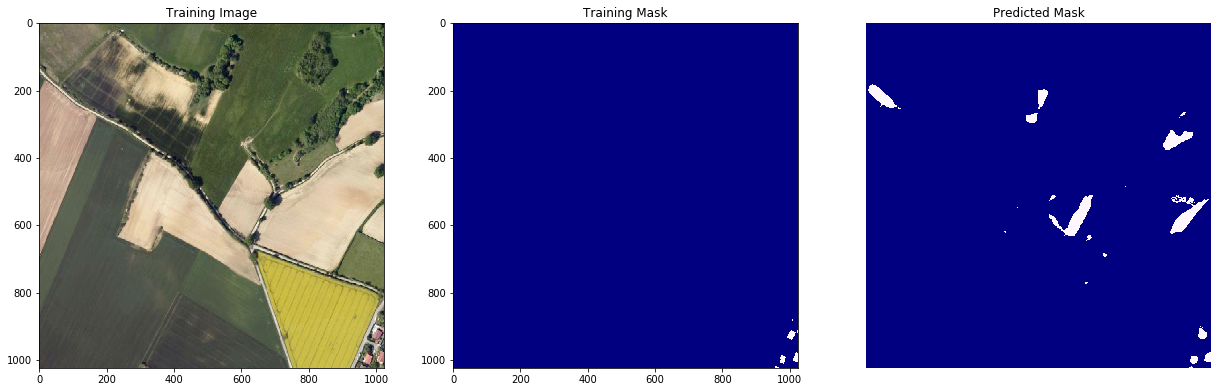

Lyon_0_2


In [16]:
model = get_unet_5()
model.load_weights('1_unet5_c1.hdf5')
img_id = Image_ID[2]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)


(1024, 1024, 3)


True


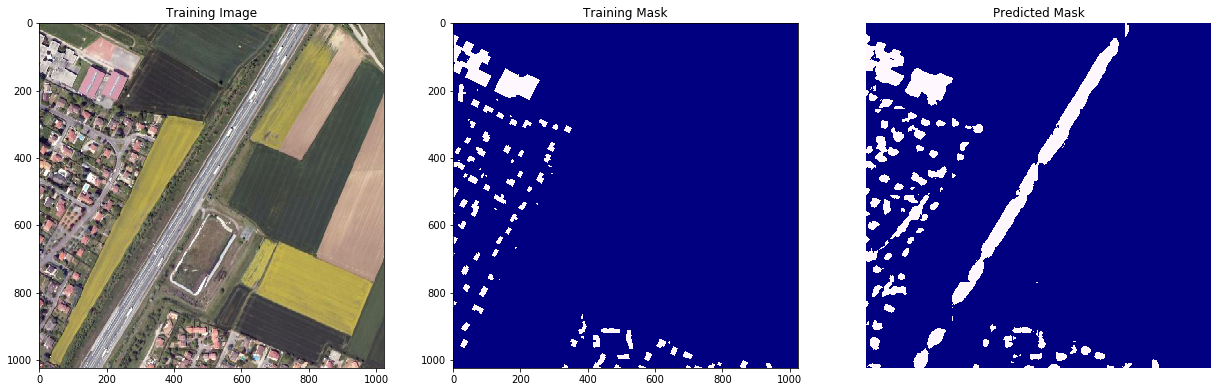

Lyon_0_1


In [17]:
model = get_unet_5()
model.load_weights('1_unet5_c1.hdf5')
img_id = Image_ID[1]
check_predict(model, 0.5, img_id=img_id, Class_Type=1)
print(img_id)
